In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from gensim.models import Word2Vec
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.metrics import mean_squared_error
from collections import Counter, defaultdict
import re
import textwrap
import bitsandbytes
import torch
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer
from transformers.utils import logging
import warnings
from upsetplot import from_contents, UpSet
import seaborn as sns
from itertools import combinations
import networkx as nx

logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=FutureWarning)


bin c:\NLP\Final-project\Project3\.venv\lib\site-packages\bitsandbytes\libbitsandbytes_cpu.so
function 'cadam32bit_grad_fp32' not found


c:\NLP\Final-project\Project3\.venv\lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
c:\NLP\Final-project\Project3\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger"])

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 2.1 MB/s eta 0:00:06
     ----- ---------------------------------- 1.8/12.8 MB 3.6 MB/s eta 0:00:04
     -------- ------------------------------- 2.6/12.8 MB 3.9 MB/s eta 0:00:03
     ----------- ---------------------------- 3.7/12.8 MB 4.0 MB/s eta 0:00:03
     ------------- -------------------------- 4.5/12.8 MB 4.0 MB/s eta 0:00:03
     ----------------- ---------------------- 5.5/12.8 MB 4.1 MB/s eta 0:00:02
     -------------------- ------------------- 6.6/12.8 MB 4.2 MB/s eta 0:00:02
     ---------------------- ----------------- 7.3/12.8 MB 4.2 MB/s eta 0:00:02
     -------------------------- ------------- 8.4/12.8 MB 4.3 MB/s eta 0:00:02
     ----------------------------- ---------- 9.4/12.8 MB 4.3 MB/s eta 0:00:01
     ------------------------------- -------- 10.2/12.8 MB 4.3 MB/

2025-07-09 18:32:47.027920: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



### Graphs plotting functions

In [ ]:
def create_bar_chart(data, title, xlabel, ylabel):
    plt.figure(figsize=(14, 8)) 
    wrapped_labels = [ '\n'.join(textwrap.wrap(str(label), 15)) for label in data.index ]
    ax = data.plot(kind='bar', color='cornflowerblue', edgecolor='black')
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    plt.xticks(ticks=range(len(data)), labels=wrapped_labels, rotation=90, ha='center', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for p in ax.patches:
        height = p.get_height()
        if isinstance(height, int) or height.is_integer():
            label = f'{int(height)}'
        else:
            label = f'{height:.3f}'
        ax.annotate(label,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

def create_line_chart(data, title, xlabel, ylabel):
    plt.figure(figsize=(14, 8))
    data = data.copy()
    data.index = pd.to_numeric(data.index, errors='coerce')
    data = data.dropna().sort_index()
    ax = plt.gca()
    ax.plot(data.index, data.values, marker='o', color='cornflowerblue', linewidth=2, markersize=6)
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(data.index, rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for x, y in zip(data.index, data.values):
        label = f'{int(y)}' if y == int(y) else f'{y:.3f}'
        yrange = max(data.values) - min(data.values)
        offset = 0.02 * yrange
        ax.text(x, y + offset, label, ha='center', va='bottom', fontsize=11)
    plt.tight_layout()
    plt.show()
    
def create_grouped_bar_chart(indices, group1, group2, title, xlabel, ylabel):
    width = 0.35
    x = np.arange(len(indices))
    fig, ax = plt.subplots(figsize=(14, 8))
    bars1 = ax.bar(x - width/2, group1, width, label='Group 1', color='cornflowerblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, group2, width, label='Group 2', color='lightcoral', edgecolor='black')
    ax.set_title(title, fontsize=18, weight='bold')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(indices, rotation=90, ha='center', fontsize=10)
    ax.legend()
    for bar in bars1 + bars2:
        height = bar.get_height()
        if isinstance(height, int) or height.is_integer():
            label = f'{int(height)}'
        else:
            label = f'{height:.3f}'
        ax.annotate(label,
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

def create_bins_chart(data, title, xlabel, ylabel, bins_number=30):
    plt.hist(data, bins=bins_number, color='skyblue', edgecolor='black')
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.show()
    
def create_wordcloud(scored_tokens, title):
    wordcloud = WordCloud(width=1000,height=500,background_color='white',colormap='viridis',prefer_horizontal=0.9,scale=2,font_step=1).generate_from_frequencies(scored_tokens)
    plt.figure(figsize=(14, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=24, fontweight='bold', pad=20)
    plt.tight_layout(pad=5)
    plt.show()

### Combining Author(given by the author) and Index(given by Scopus) keywords into one column, removing some redundant keywords present mostly in the index keywords

In [ ]:
def combine_keywords(df):
    author_kws = df['Author Keywords'].fillna('').str.split(';')
    index_kws = df['Index Keywords'].fillna('').str.split(';')

    stop_keywords = {'man', 'woman', 'review', 'middle aged', 'very elderly', 'male', 'fiber lasers', 'fibers', 'follow up', 'female', 'nonhuman', 'surveys', 'young adult', 'human', 'study', 'method', 'algorithms', 'article', 'adult', 'simple++', 'humans', "'current"}
    combined_keywords = []

    for a_kws, i_kws in zip(author_kws, index_kws):
        kws = set()
        if a_kws:
            kws.update([kw.strip().lower() for kw in a_kws if kw])
        if i_kws:
            kws.update([kw.strip().lower() for kw in i_kws if kw])
        kws = {kw for kw in kws if kw not in stop_keywords}
        combined_keywords.append(list(kws))

    return combined_keywords

### 1. Loading the articles data from Scopus: having 1000 articles from each year from 2015-2025 - 11000 articles in total

In [ ]:
articles_df = pd.read_csv('scopus_articles_data.csv')
articles_df['Combined Keywords'] = combine_keywords(articles_df)
articles_df.head(10)

Authors  \
0  Banerjee P.S.; Sahoo G.; Chakraborty B.; Baner...   
1  Wang D.; Yang X.; Xu J.; Chen Y.; Wang N.; Liu...   
2                                                NaN   
3                   Zaharia C.; Reiner M.; Schütz P.   
4  Venturi G.; Bellandi T.; Dell'Orletta F.; Mont...   
5            Francopoulo G.; Mariani J.; Paroubek P.   
6                              Onal K.D.; Karagoz P.   
7  Wang Y.; Luo J.; Hao S.; Xu H.; Shin A.Y.; Jin...   
8             Schneider N.; Flanigan J.; O'Gorman T.   
9  Park A.; Hartzler A.L.; Huh J.; McDonald D.W.;...   

                                   Author full names  \
0  Banerjee, P.S. (56988506500); Sahoo, G. (23974...   
1  Wang, Dandan (56472066500); Yang, Xiaohui (564...   
2                                                NaN   
3  Zaharia, Cətəlin (58335145600); Reiner, Melita...   
4  Venturi, Giulia (27568199800); Bellandi, Tomma...   
5  Francopoulo, Gil (6504343543); Mariani, Joseph...   
6  Onal, Kezban Dilek (56204304400); Karagoz, Pin...   
7  Wang, Yue (57200067965); Luo, Jin (56763099400...   
8  Schneider, Nathan (55105823100); Flanigan, Jef...   
9  Park, Albert (56814315800); Hartzler, Andrea L...   

                                        Author(s) ID  \
0  56988506500; 23974926800; 35092118100; 5643904...   
1  56472066500; 56472314700; 54796280200; 5711460...   
2                                                NaN   
3              58335145600; 57187915100; 35754936100   
4  27568199800; 6506959826; 57540567000; 15056781100   
5                6504343543; 7005470617; 55799033100   
6                           56204304400; 24558798100   
7  57200067965; 56763099400; 56516111700; 5676303...   
8              55105823100; 55149217900; 55647670500   
9  56814315800; 39061612500; 22834683600; 3557825...   

                                               Title  Year  \
0  Fluctuating pattern size handling for the extr...  2015   
1  A Hybrid Transliteration Model for Chinese/Eng...  2015   
2  NAACL-HLT 2015 - 2015 Conference of the North ...  2015   
3  Evidence-based Neuro linguistic psychotherapy:...  2015   
4  NLP-Based Readability Assessment of Health-Rel...  2015   
5  NLP4NLP: Applying NLP to scientific corpora ab...  2015   
6  Named entity recognition from scratch on socia...  2015   
7  NLP based congestive heart failure case findin...  2015   
8  The logic of AMR: Practical, unified, graph-ba...  2015   
9  Automatically detecting failures in natural la...  2015   

                                        Source title     Volume    Issue  \
0      Advances in Intelligent Systems and Computing        338      NaN   
1  Proceedings of the Annual Meeting of the Assoc...  2015-July      NaN   
2  NAACL-HLT 2015 - 2015 Conference of the North ...        NaN      NaN   
3                               Psychiatria Danubina         27        4   
4  EMNLP 2015 - 6th International Workshop on Hea...        NaN      NaN   
5                          CEUR Workshop Proceedings       1384  January   
6                          CEUR Workshop Proceedings       1521      NaN   
7       International Journal of Medical Informatics         84       12   
8  NAACL-HLT 2015 - 2015 Conference of the North ...        NaN      NaN   
9               Journal of Medical Internet Research         17        8   

  Art. No. Page start  ...  CODEN   PubMed ID  Language of Original Document  \
0      NaN        405  ...    NaN         NaN                        English   
1      NaN         67  ...    NaN         NaN                        English   
2      NaN        NaN  ...    NaN         NaN                        English   
3      NaN        355  ...  PSYDE  26609647.0                        English   
4      NaN        131  ...    NaN         NaN                        English   
5      NaN          5  ...    NaN         NaN                        English   
6      NaN          2  ...    NaN         NaN                        English   
7      NaN       1039  ...  IJMIF 

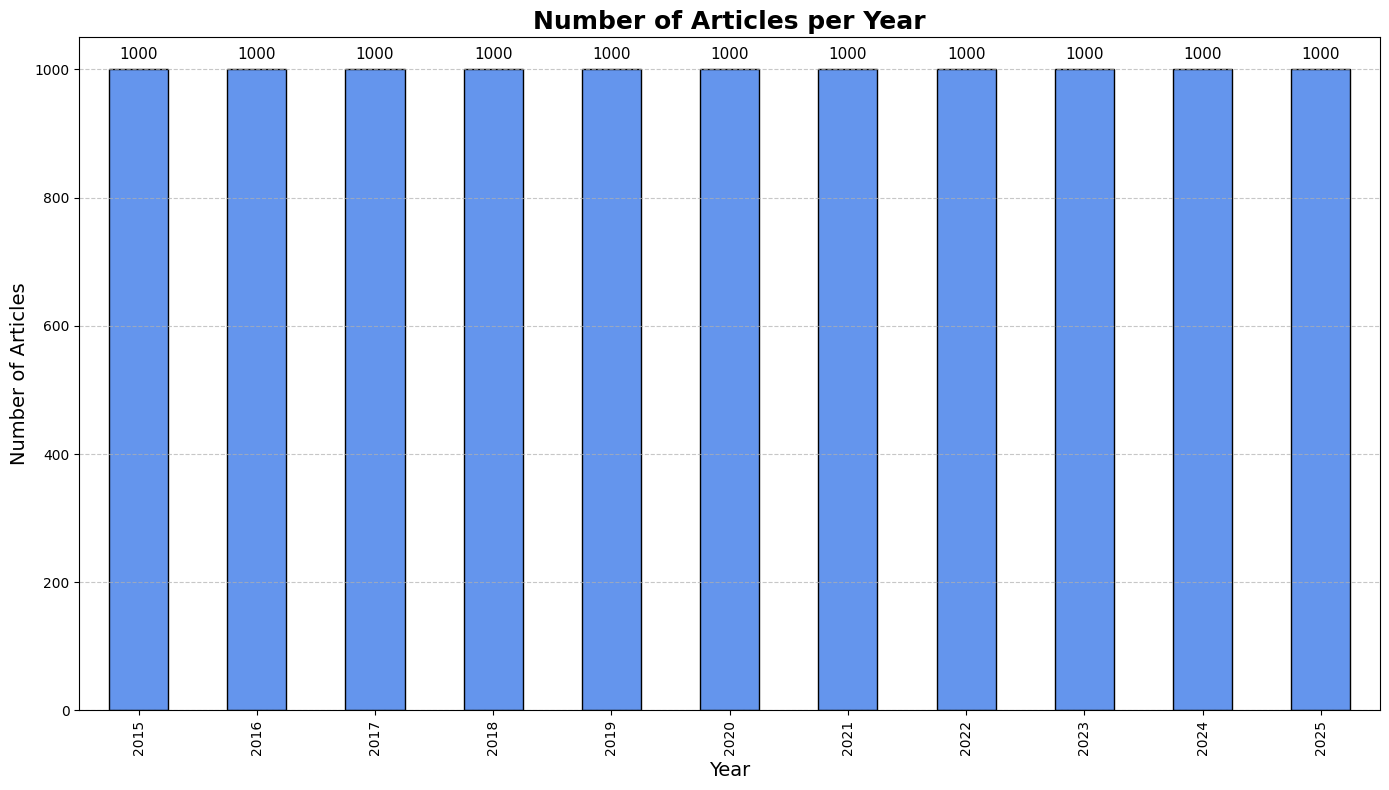

In [ ]:
articles_per_year = articles_df['Year'].value_counts().sort_index()
create_bar_chart(articles_per_year, "Number of Articles per Year", "Year", "Number of Articles")

In [ ]:
abstracts = articles_df['Abstract'].dropna().tolist()

### 2. Pre-processing the article's abstracts

In [ ]:
def preprocess_texts(texts):
    def process_text(text):
        return ' '.join([
            token.lemma_.lower()
            for token in text
            if not token.is_stop and not token.is_punct and token.lemma_.isalpha()
        ])

    return [process_text(text) for text in nlp.pipe(texts, batch_size=50, n_process=4)]

processed_abstracts = preprocess_texts(abstracts)
print(abstracts[0:5])
print(processed_abstracts[0:5])


['Natural Language Processing (NLP) is a very important part of a conversation as well as that of a chatterbot. Complete vocabulary building for a chatterbot is a cumbersome and time intensive process and thus a self learning chatterbot is a much more efficient alternative. The learning process can be initiated by a multidimensional approach including individual words to phrases and the whole concepts. Verbs tend to be a constant feature since they have different forms, namely participles and tenses. Even though we will discuss the algorithm to derive the base verb from any participle or tense but for storing such data items it a special kind of data handling is required. In this regard we will be discussing and proposing the fluctuating data handling strategy which will help us not just to understand the strategy of fluctuating data handling but also its correlation with data handling for smaller databases. © 2015, Springer International Publishing Switzerland.', 'This paper presents 

### 3. Extracting the most common words in abstracts using TF-IDF - those with the highest scores

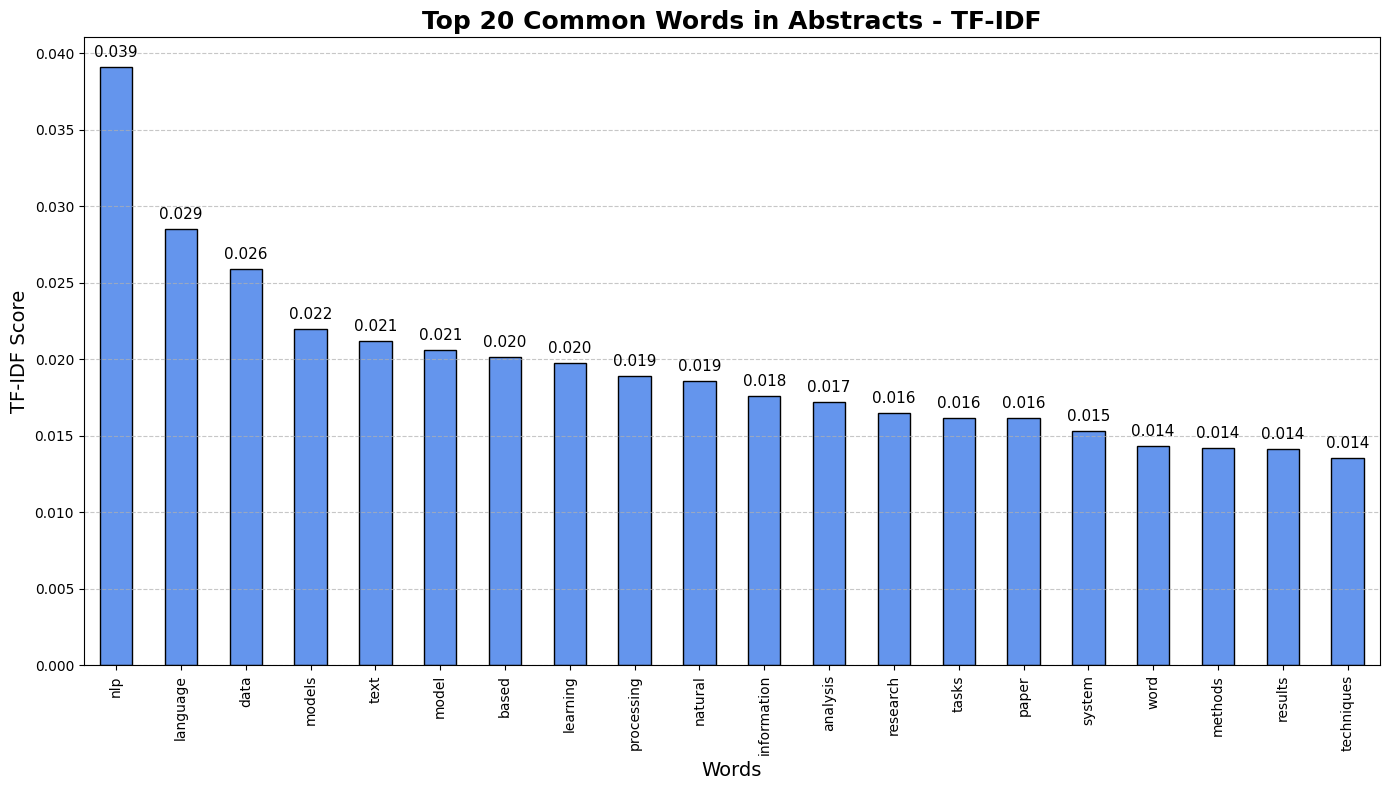

In [ ]:
def extract_top_tfidf_words(texts, top_n=20):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(texts)
    tfidf_scores = X.mean(axis=0).A1 
    words = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame({'word': words, 'score': tfidf_scores})
    tfidf_df = tfidf_df.sort_values(by='score', ascending=False).head(top_n)
    return tfidf_df

top_words_df = extract_top_tfidf_words(processed_abstracts)
create_bar_chart(pd.Series(top_words_df['score'].values, index=top_words_df['word']), "Top 20 Common Words in Abstracts - TF-IDF", "Words", "TF-IDF Score")
create_wordcloud(dict(zip(top_words_df['word'], top_words_df['score'])), "Top 20 Common Words in Abstracts - TF-IDF")


### 4. Extracting the most common words in abstracts using Word2Vec.
### High min_count makes sure the words sampled aren't ones that don't appear often and will apply more weight into the averaged vector, the words most close to it are picked

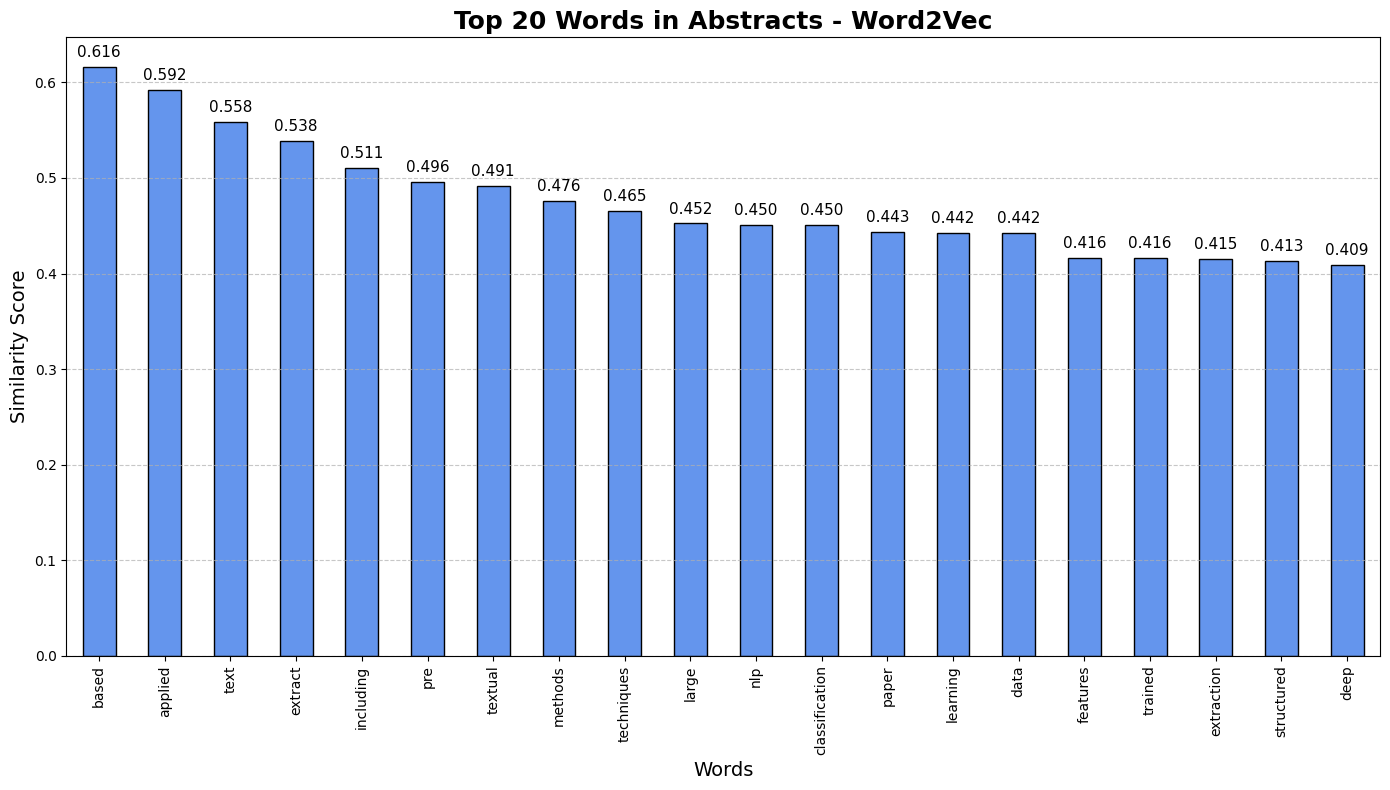

In [ ]:
abstracts_splitted_tokens = [text.split() for text in processed_abstracts]
model = Word2Vec(sentences=abstracts_splitted_tokens, vector_size=300, window=7, min_count=1000, workers=1, seed=42)

all_tokens = [token for tokens in abstracts_splitted_tokens for token in tokens if token in model.wv]
mean_vector = sum(model.wv[token] for token in all_tokens) / len(all_tokens)
similar_words = model.wv.similar_by_vector(mean_vector, topn=20)
words, scores = zip(*similar_words)

create_bar_chart(pd.Series(scores, index=words), "Top 20 Words in Abstracts - Word2Vec", "Words", "Similarity Score")
create_wordcloud(dict(similar_words), "Top 20 Words in Abstracts - Word2Vec")


### 5. Extracting the most common words in abstracts using AutoEncoder
### I have picked up the words that the decoder had the most trouble reconstructing - thus were harder to compress - thus are more distinct and often important 




258/258 [==============================] - 0s 522us/step
Top 20 words with highest reconstruction error:


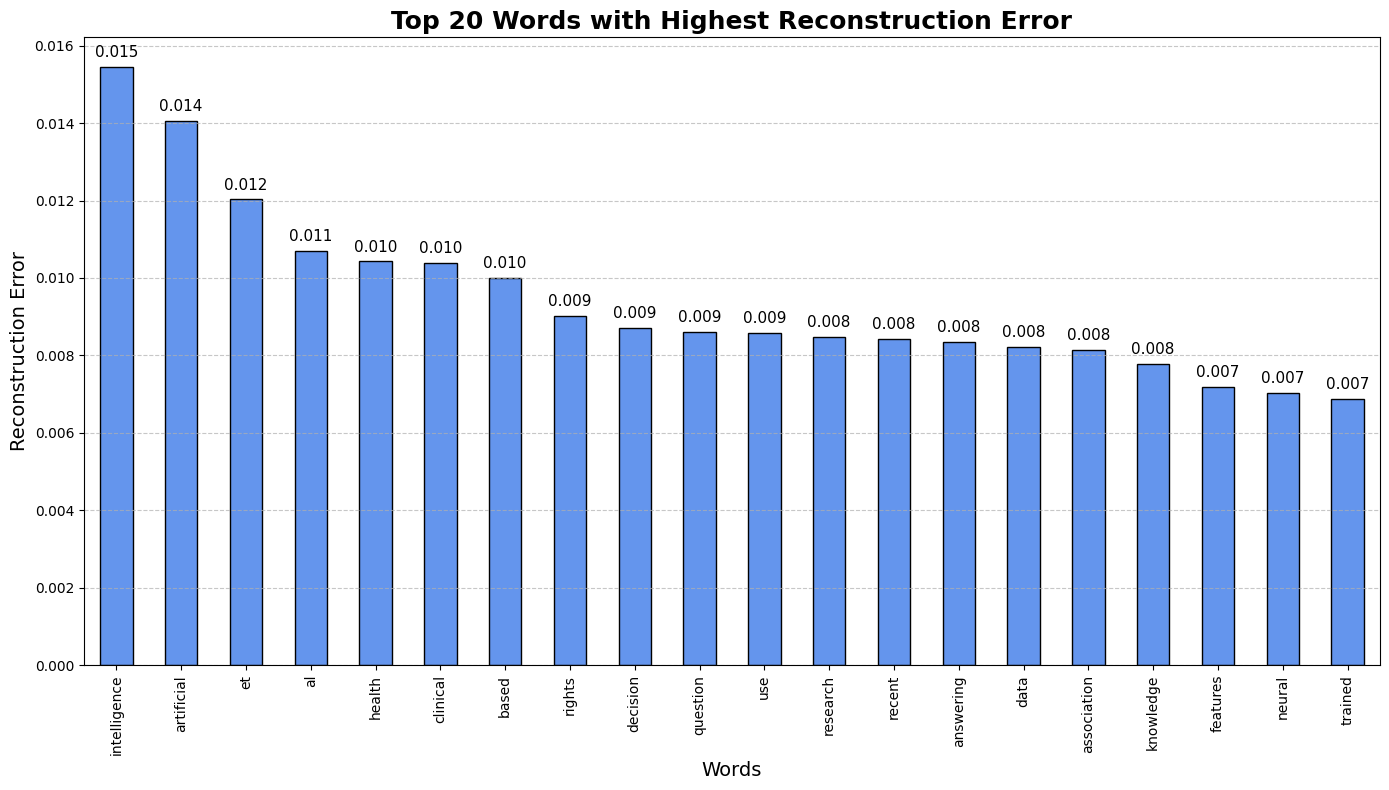

In [ ]:
model = Word2Vec(sentences=abstracts_splitted_tokens, vector_size=300, window=7, min_count=10, workers=1, seed=42)
words = model.wv.index_to_key
vectors = np.array([model.wv[word] for word in words])
input_dim = vectors.shape[1]

# the autoencoder gets the Word2Vec vectors as input
input_layer = Input(shape=(input_dim,))
# the encoder compresses the input vectors to a lower dimension
encoded = Dense(128, activation='relu')(input_layer)
# the decoder reconstructs the original vectors from the compressed representation
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(vectors, vectors, epochs=50, batch_size=256, shuffle=True, verbose=0)

predicted_vectors = autoencoder.predict(vectors)
errors = [mean_squared_error(vectors[i], predicted_vectors[i]) for i in range(len(vectors))]
word_errors = list(zip(words, errors))
word_errors_sorted = sorted(word_errors, key=lambda x: x[1], reverse=True)
print(f"Top 20 words with highest reconstruction error:")
create_bar_chart(pd.Series([error for _, error in word_errors_sorted[:20]], index=[word for word, _ in word_errors_sorted[:20]]),
                  "Top 20 Words with Highest Reconstruction Error", "Words", "Reconstruction Error")
create_wordcloud(dict(word_errors_sorted[:20]), "Top 20 Words with Highest Reconstruction Error - Autoencoder")

### 6. The differences between 3-5
### Showing the intersection between the 3 groups and the actual most common words
### TF-IDF - the most useful for finding common words as they usually get high score.
### Word2Vec - isn't often used for this mission - but making sure encoding words appearing in part of the articles helped
### Autoencoder - found words that hard to compress - thus not necessary common but rather important and unique semantically    

In [ ]:
top_tfidf_words = set(top_words_df['word'])
top_word2vec_words = set(word for word, _ in similar_words)
top_autoencoder_words = set(word for word, _ in word_errors_sorted[:20])
actual_common_words = model.wv.index_to_key[:20]
print(f"Actual top common words: {actual_common_words}")
print(f"Common words in all three methods: {top_tfidf_words.intersection(top_word2vec_words).intersection(top_autoencoder_words)}")
print(f"Common words in TF-IDF and Word2Vec: {top_tfidf_words.intersection(top_word2vec_words)}")
print(f"Common words in TF-IDF and autoencoder: {top_tfidf_words.intersection(top_autoencoder_words)}")
print(f"Common words in Word2Vec and autoencoder: {top_word2vec_words.intersection(top_autoencoder_words)}")

set_dict = {
    'TF-IDF': top_tfidf_words,
    'Word2Vec': top_word2vec_words,
    'Autoencoder': top_autoencoder_words,
    'Actual most common': set(actual_common_words)
}
upset_data = from_contents(set_dict)
upset = UpSet(upset_data, subset_size='count', show_counts=True, sort_by='degree').plot()
plt.title("Intersection of Top Words Across Methods")
plt.show()

Actual top common words: ['nlp', 'language', 'data', 'processing', 'natural', 'based', 'models', 'model', 'text', 'learning', 'information', 'analysis', 'results', 'paper', 'research', 'methods', 'system', 'study', 'tasks', 'performance']
Common words in all three methods: {'data', 'based'}
Common words in TF-IDF and Word2Vec: {'nlp', 'data', 'text', 'based', 'learning', 'paper', 'methods', 'techniques'}
Common words in TF-IDF and autoencoder: {'data', 'research', 'based'}
Common words in Word2Vec and autoencoder: {'data', 'features', 'trained', 'based'}


### 7. Performing NER

In [ ]:
nlp.enable_pipe("ner")
def extract_entities(texts):
    entities = []
    for doc in nlp.pipe(texts, batch_size=50, n_process=4):
        for ent in doc.ents:
            entities.append((ent.text, ent.label_))
    return entities
entities = extract_entities(abstracts)

Top 20 entities seen with their types:


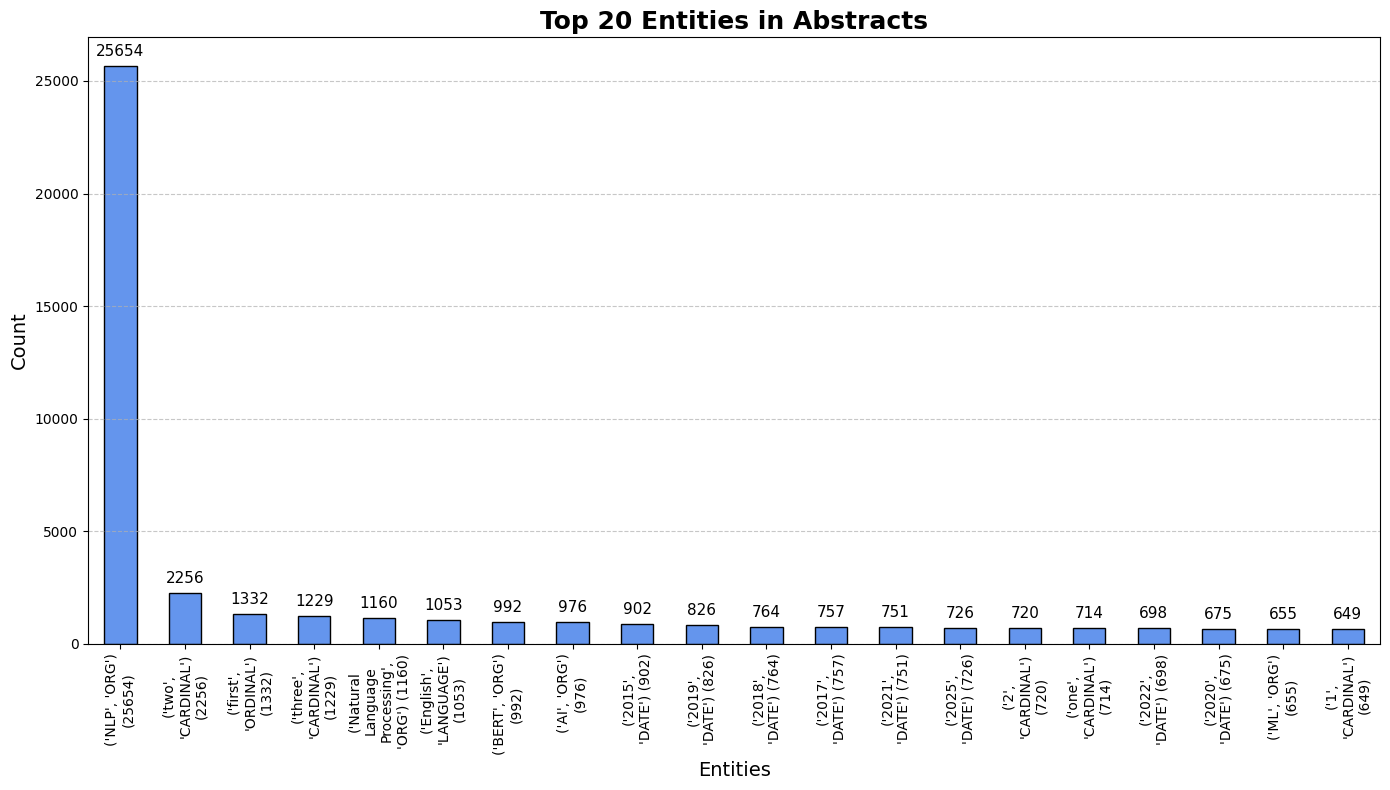

Common ORGs: {'the Natural Language Processing', 'Springer Science+Business Media', 'BLEU', 'SVM', 'Natural Language Processing', 'Association for the Advancement of Artificial Intelligence', 'Amazon', 'COVID-19', 'QA', 'F', 'NLU', 'STS', 'Taylor & Francis Group', 'ML', 'ACM', 'CT', 'Informa UK Limited', 'CNN', 'Support Vector Machine', 'SRL', 'European Language Resources Association', 'Machine Learning', 'RDF', 'Convolutional Neural Network', 'PPV', 'ACL', 'DL', 'Question Answering', '2023 Association for Computational Linguistics', 'Springer Nature Switzerland AG', 'WordNet', 'Information Retrieval', 'Stanford', 'BERT', 'NER', 'Springer International Publishing', 'Google', 'Random Forest', 'XLNet', 'Artificial Intelligence', 'CRF', 'MTL', 'linear', 'Nlp', 'SQL', 'Wikipedia', 'Deep Learning', 'RNN', 'AI', '2020 Association for Computational Linguistics', 'NLI', 'API', '2022 Association for Computational Linguistics', 'FL', 'CI', 'Oxford University Press', 'Association for Computationa

In [ ]:
entity_counter = Counter(entities)
print("Top 20 entities seen with their types:")

create_bar_chart(pd.Series([count for (_, label), count in entity_counter.most_common(20)],
                            index=[f"{ent} ({label})" for (ent, label) in entity_counter.most_common(20)]),
                  "Top 20 Entities in Abstracts", "Entities", "Count")
org_counter = Counter([ent for ent, label in entities if label == "ORG"])
common_orgs = set(org for org, count in org_counter.items() if count >= 50)
print("Common ORGs:", common_orgs)

# 8 + 9. full analysis of the results is in the bibliometric analysis

## Performance analysis
### Productivity measures and general EDA

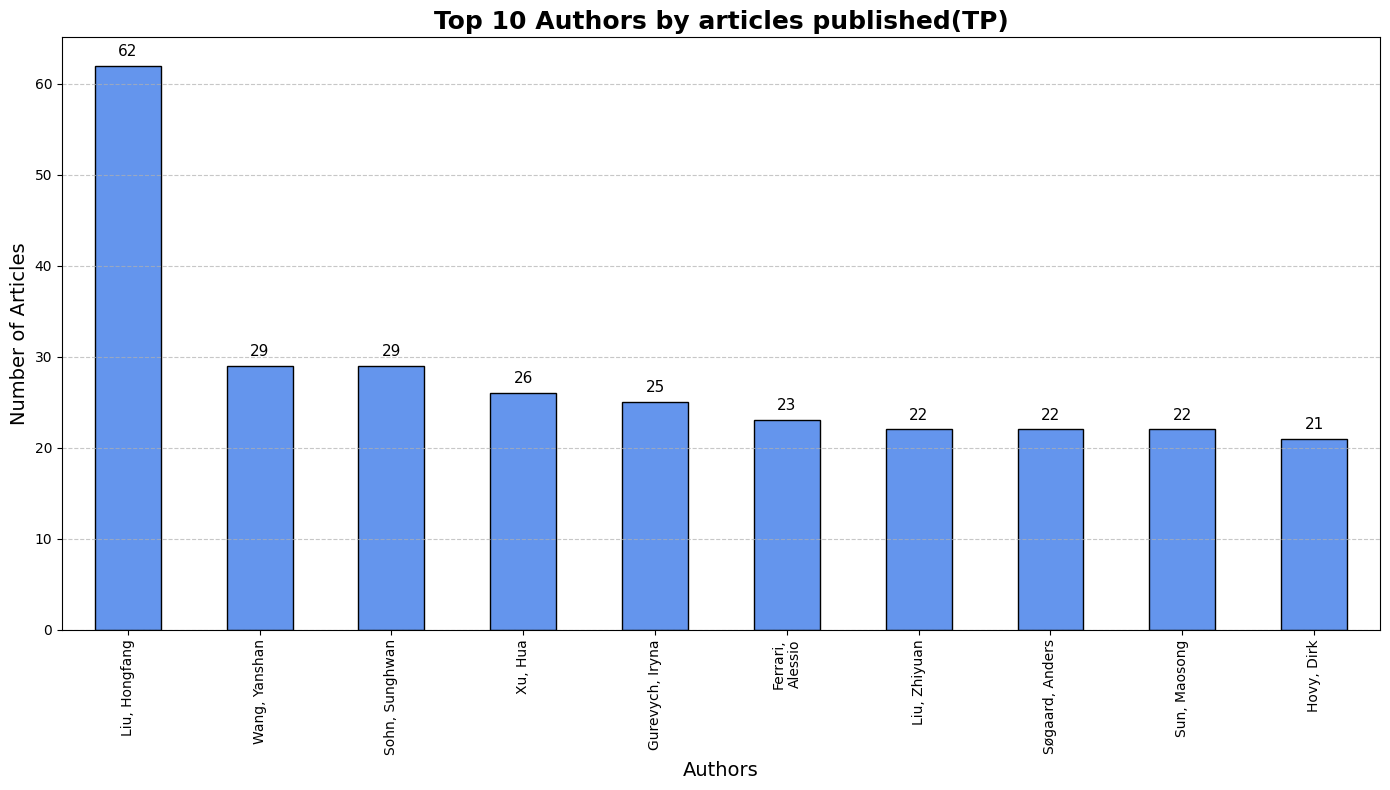

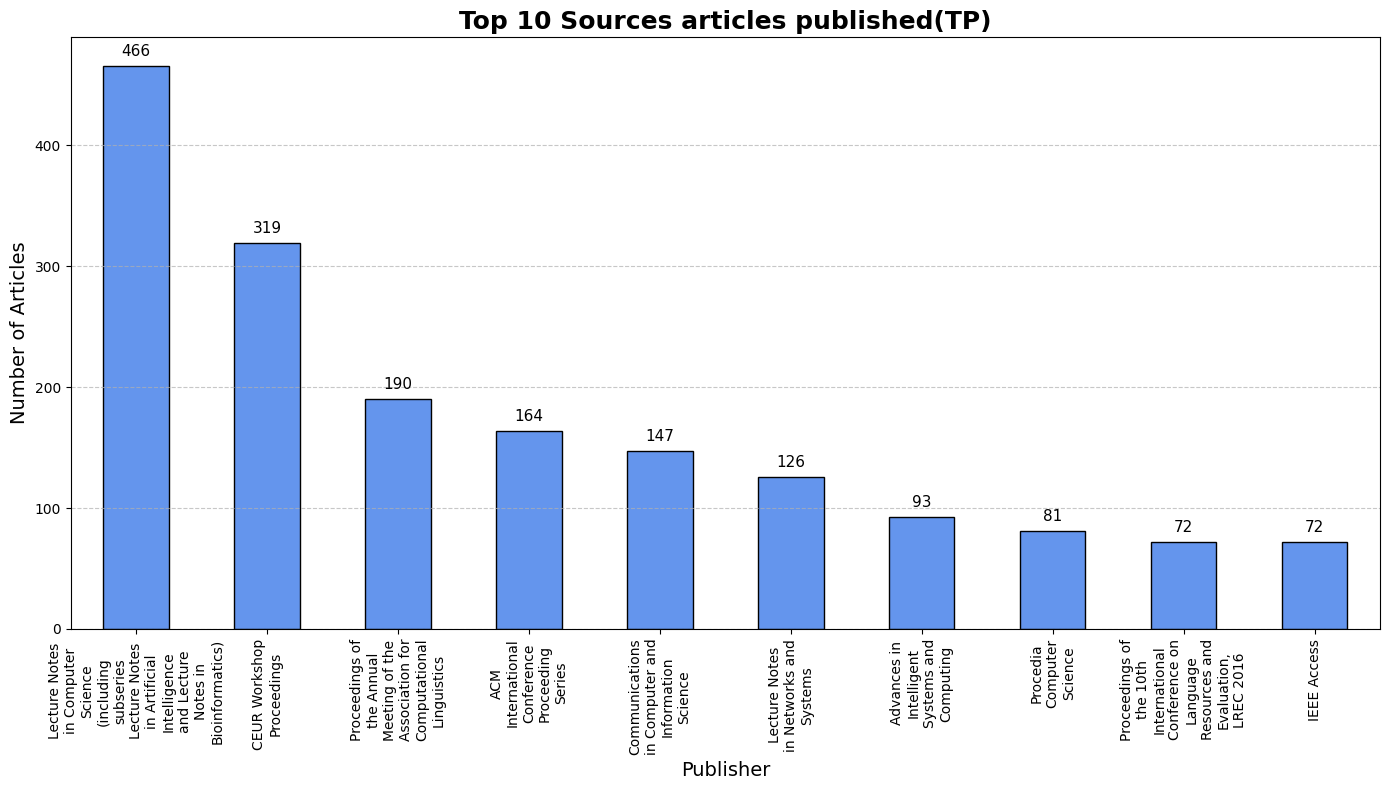

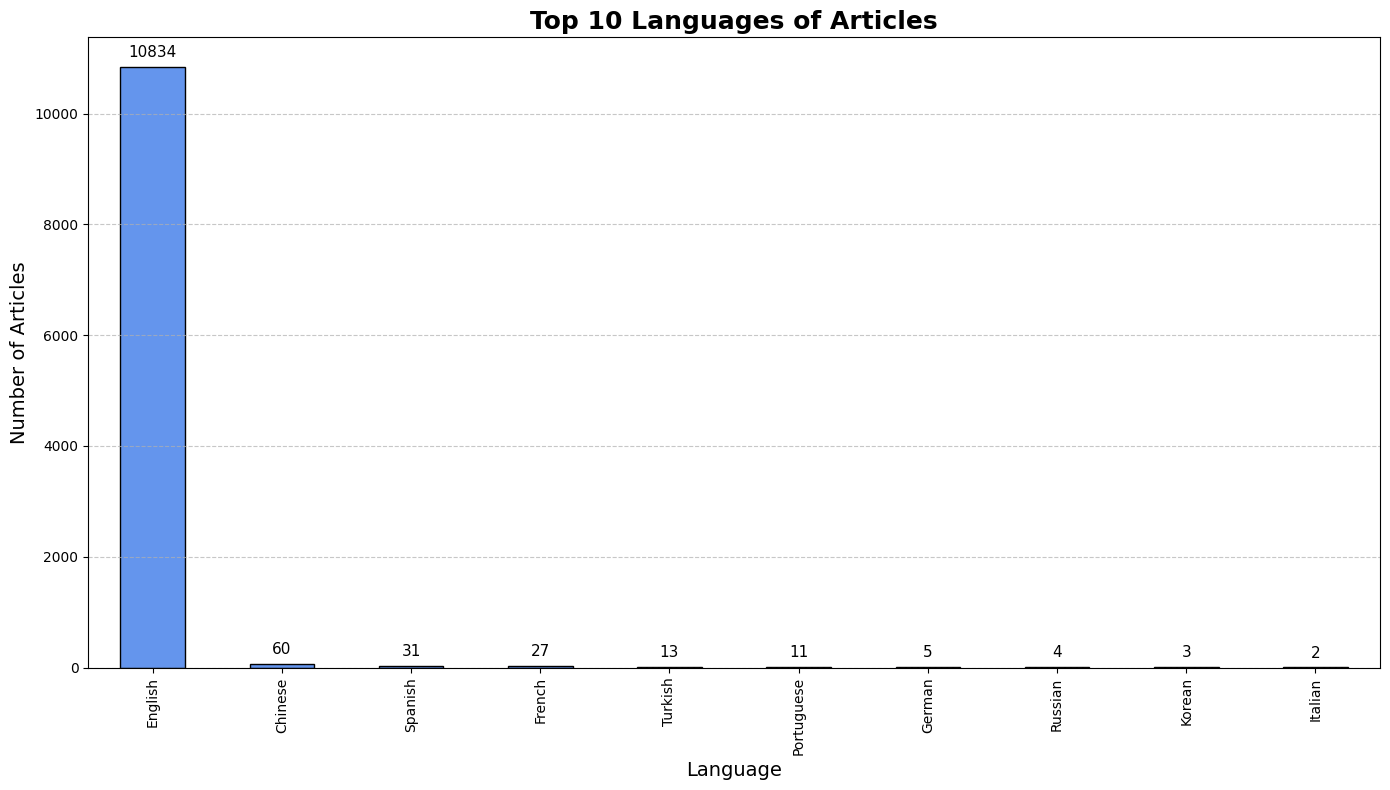

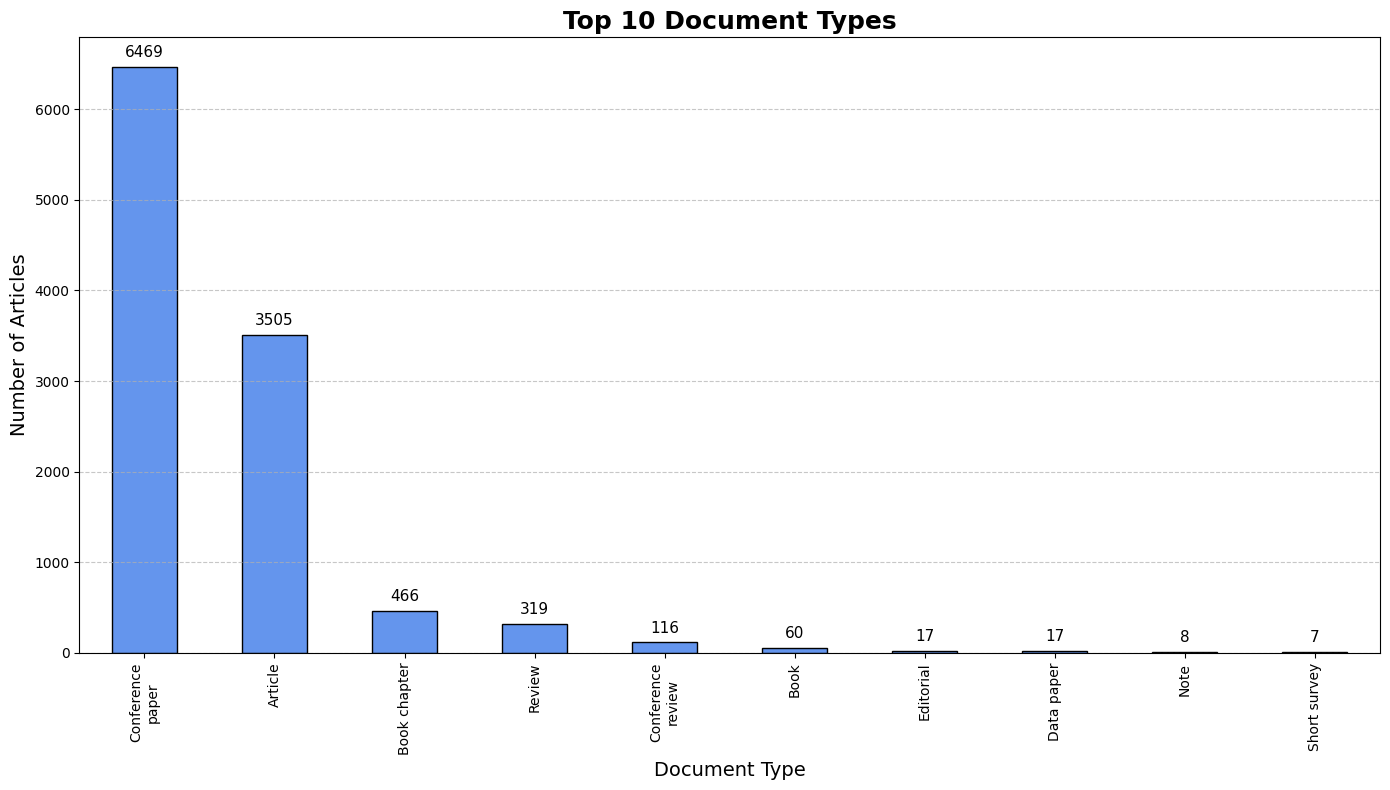

In [ ]:
all_authors = articles_df['Author full names'].dropna().str.split(';').explode().str.strip()
all_authors = all_authors.str.replace(r'\s*\(.*?\)', '', regex=True)
top_authors = all_authors.value_counts().head(10)
create_bar_chart(top_authors, "Top 10 Authors by articles published(TP)", "Authors", "Number of Articles")

top_sources = articles_df['Source title'].value_counts().head(10)
create_bar_chart(top_sources, "Top 10 Sources articles published(TP)", "Publisher", "Number of Articles")

# the most common languages used in the articles
top_languages = articles_df['Language of Original Document'].value_counts().head(10)
create_bar_chart(top_languages, "Top 10 Languages of Articles", "Language", "Number of Articles")

# the most common document types
top_doc_types = articles_df['Document Type'].value_counts().head(10)
create_bar_chart(top_doc_types, "Top 10 Document Types", "Document Type", "Number of Articles")

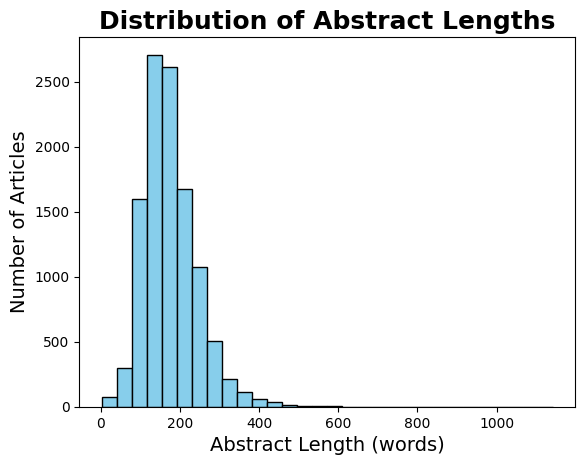

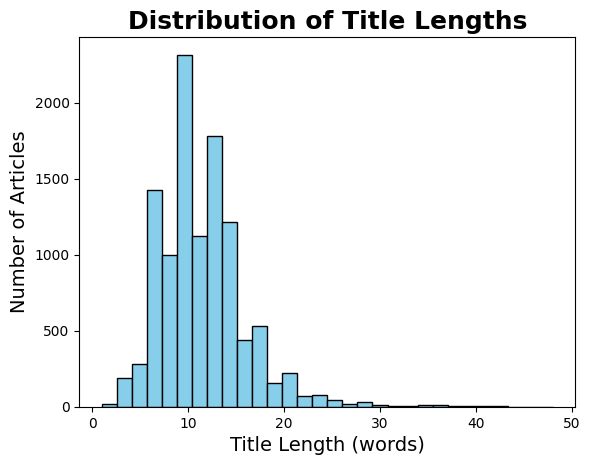

In [ ]:
abstracts_lengths = articles_df['Abstract'].dropna().apply(lambda x: len(x.split()))
create_bins_chart(abstracts_lengths, "Distribution of Abstract Lengths", "Abstract Length (words)", "Number of Articles")

title_lengths = articles_df['Title'].dropna().apply(lambda x: len(x.split()))
create_bins_chart(title_lengths, "Distribution of Title Lengths", "Title Length (words)", "Number of Articles")

### Impact measures


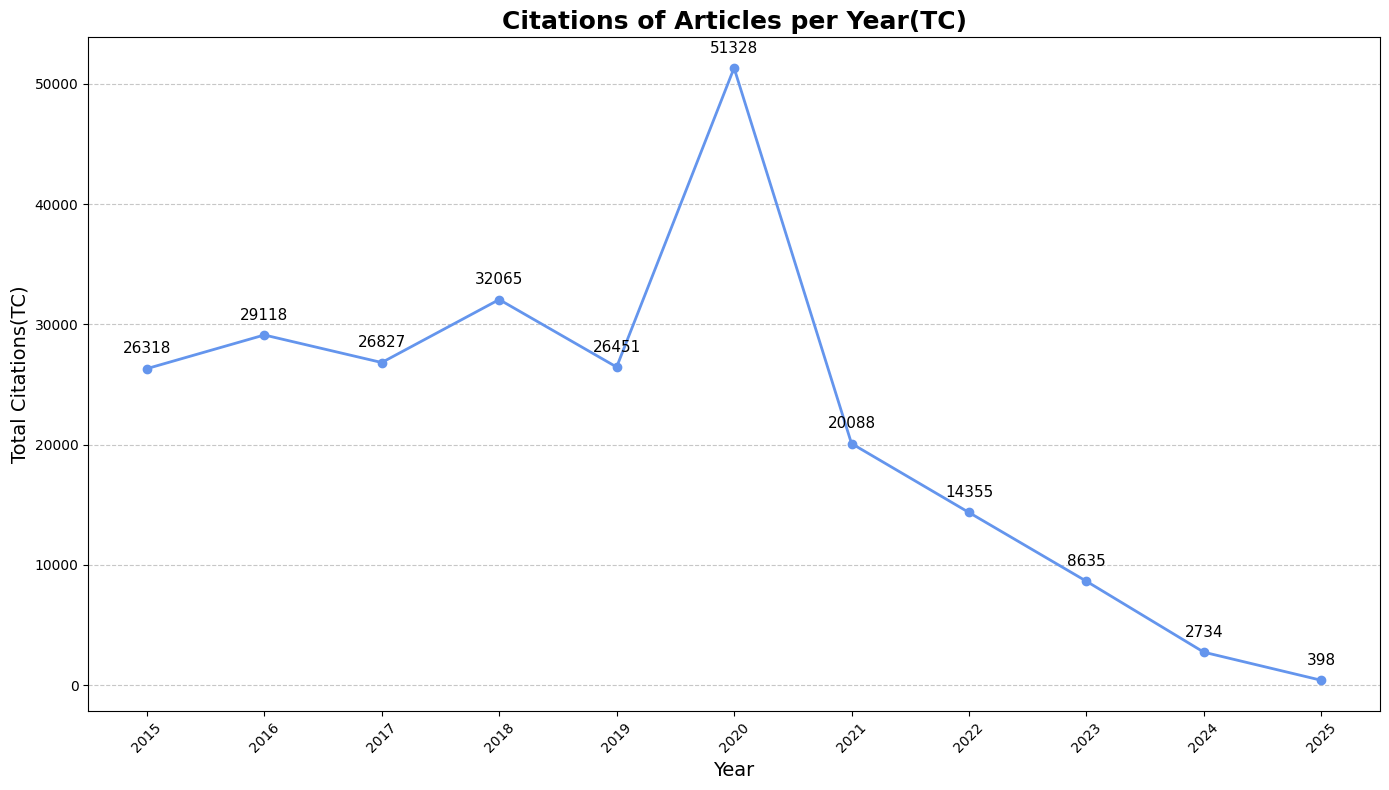

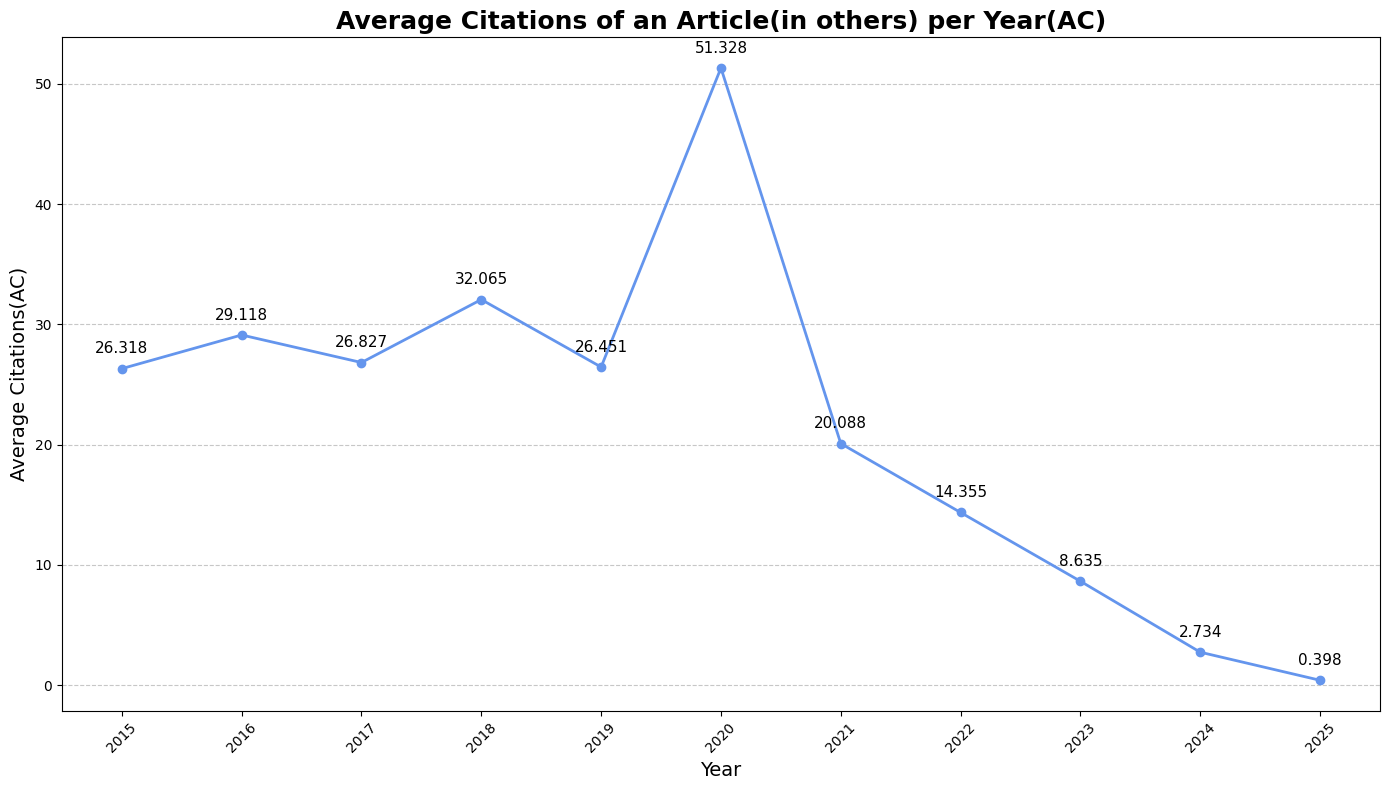

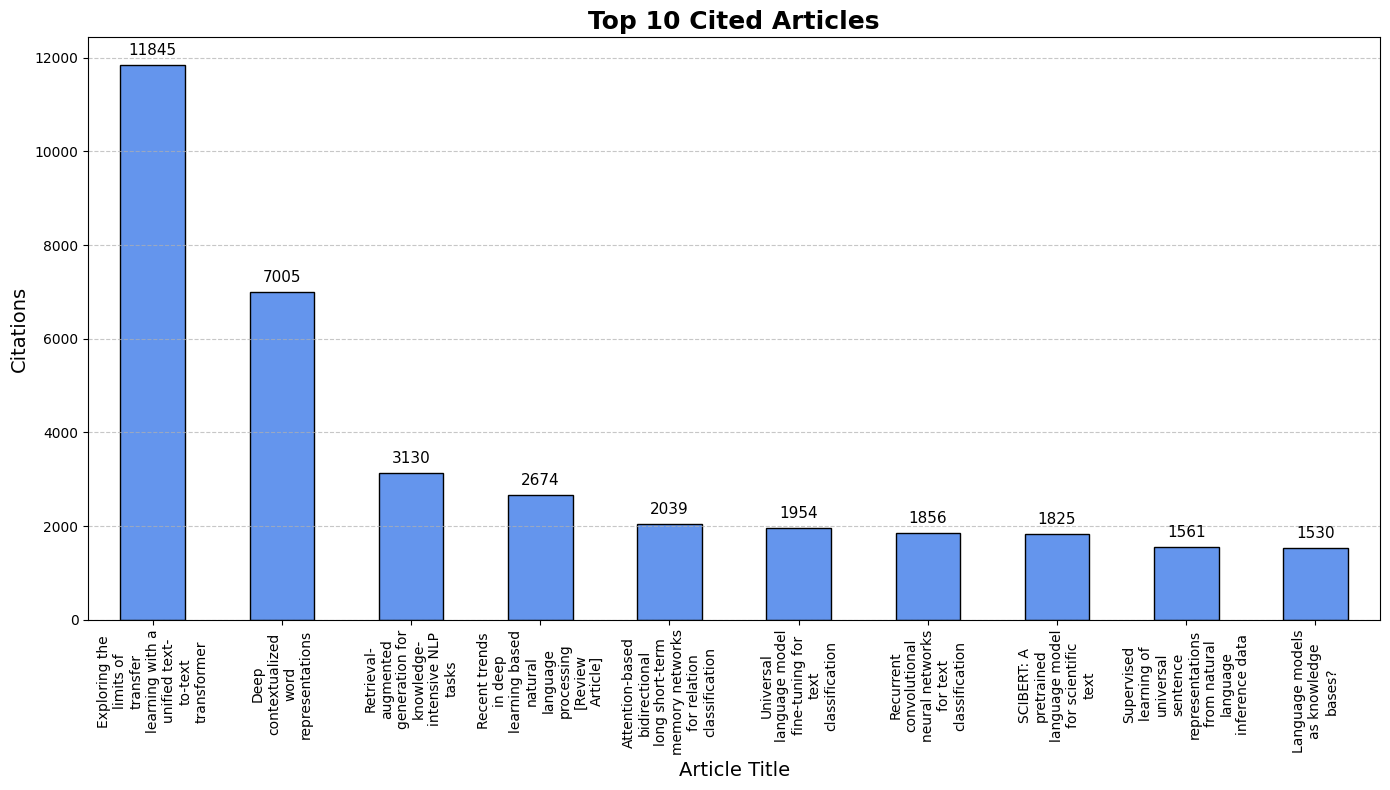

Highest cited article:
Title: Exploring the limits of transfer learning with a unified text-to-text transformer
Authors: Raffel, Colin (55354986300); Shazeer, Noam (6505939767); Roberts, Adam (57201381304); Lee, Katherine (57219622918); Narang, Sharan (57192113429); Matena, Michael (57219621868); Zhou, Yanqi (57212192242); Li, Wei (57213859463); Liu, Peter J. (57200337917)
Citations: 11845
Year: 2020
Source: Journal of Machine Learning Research
Abstract: Transfer learning, where a model is first pre-trained on a data-rich task before being finetuned on a downstream task, has emerged as a powerful technique in natural language processing (NLP). The effectiveness of transfer learning has given rise to a diversity of approaches, methodology, and practice. In this paper, we explore the landscape of transfer learning techniques for NLP by introducing a unified framework that converts all text-based language problems into a text-to-text format. Our systematic study compares pre-training obje

In [ ]:
# citations per year
citations_per_year = articles_df.groupby('Year')['Cited by'].sum().sort_index()
create_line_chart(citations_per_year, "Citations of Articles per Year(TC)", "Year", "Total Citations(TC)")

# average citations per year
avg_citations_per_year = articles_df.groupby('Year')['Cited by'].mean().sort_index()
create_line_chart(avg_citations_per_year, "Average Citations of an Article(in others) per Year(AC)", "Year", "Average Citations(AC)")

# the articles with the most citations
top_cited_articles = articles_df.nlargest(10, 'Cited by')[['Title', 'Cited by']]
create_bar_chart(top_cited_articles.set_index('Title')['Cited by'], "Top 10 Cited Articles", "Article Title", "Citations")

# the highest cited article info
highest_cited_article = articles_df.loc[articles_df['Cited by'].idxmax()]
print(f"Highest cited article:\nTitle: {highest_cited_article['Title']}\nAuthors: {highest_cited_article['Author full names']}\nCitations: {highest_cited_article['Cited by']}\nYear: {highest_cited_article['Year']}\nSource: {highest_cited_article['Source title']}\nAbstract: {highest_cited_article['Abstract']}")

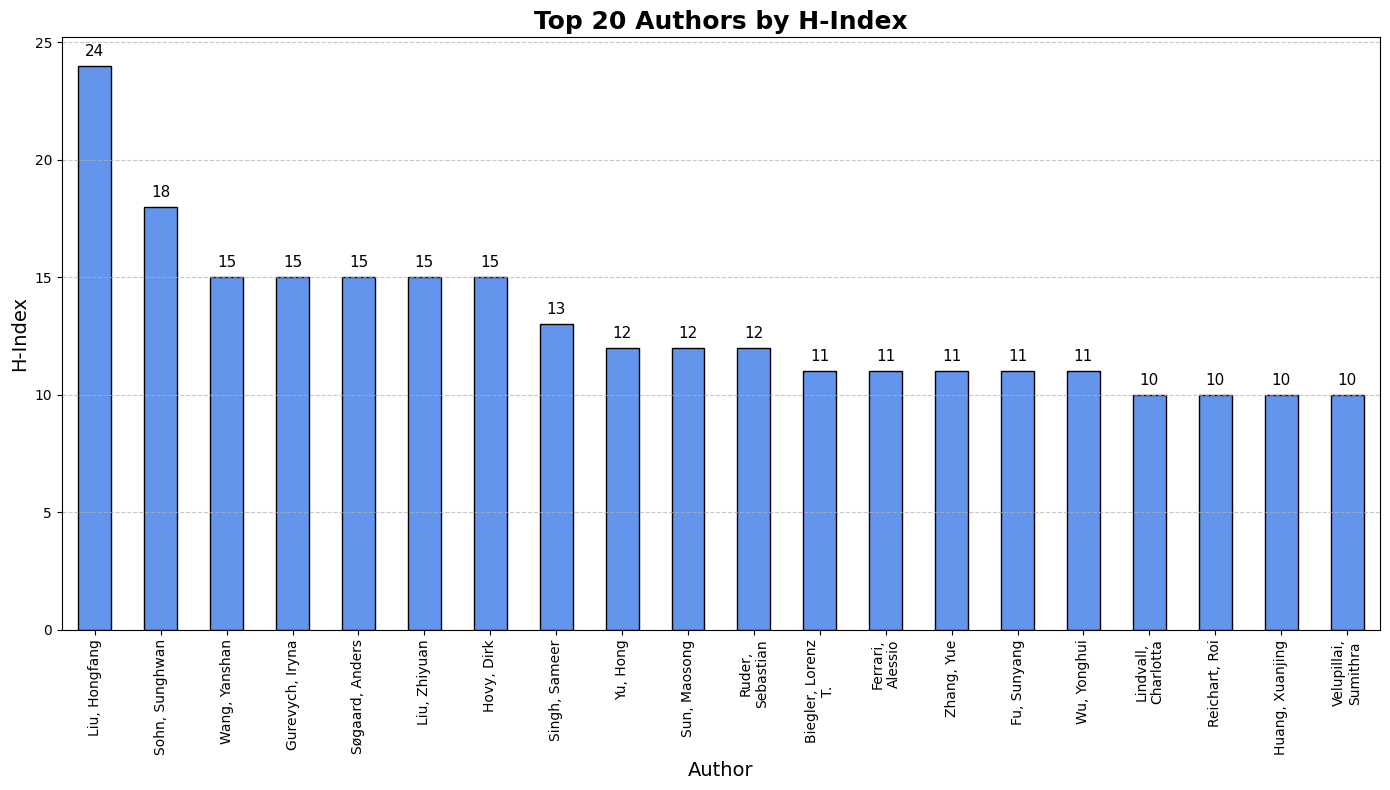

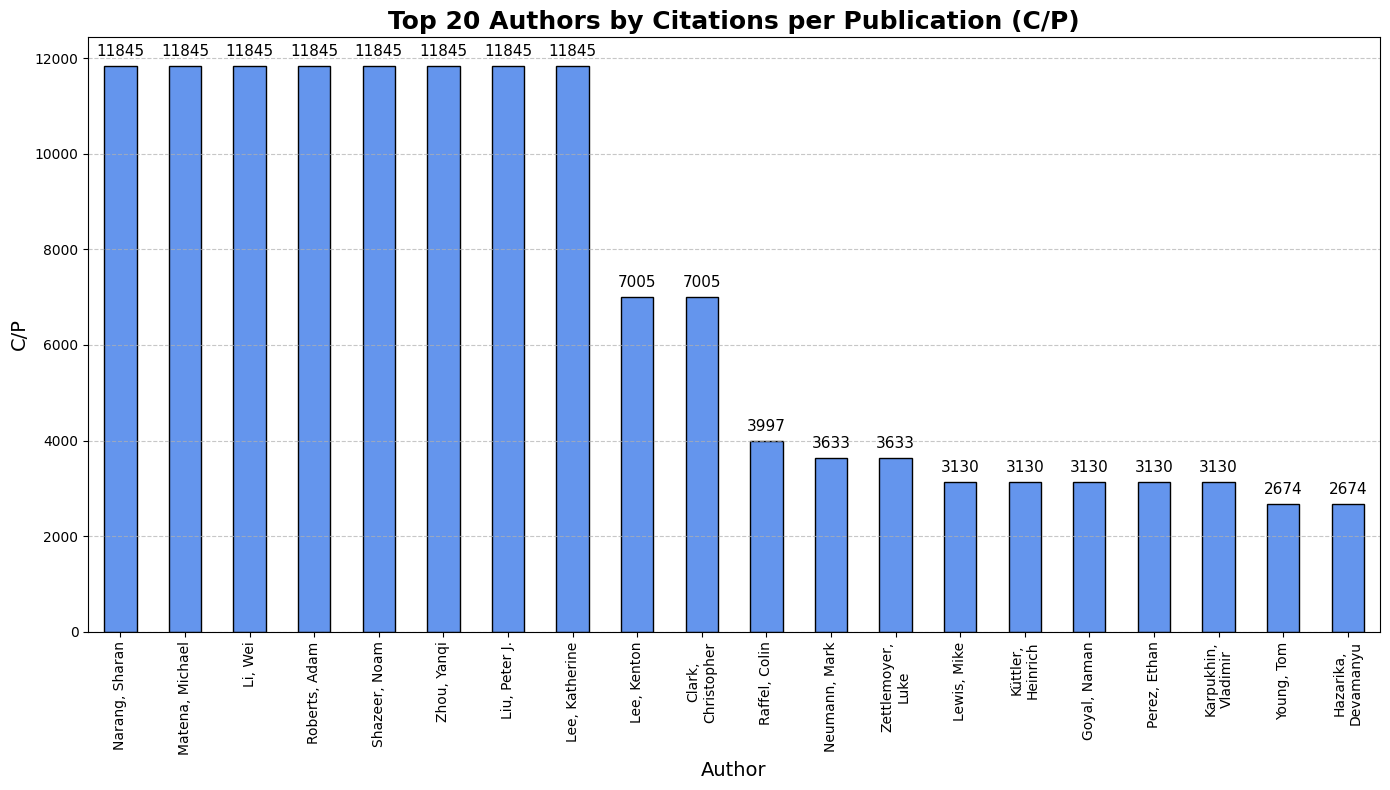

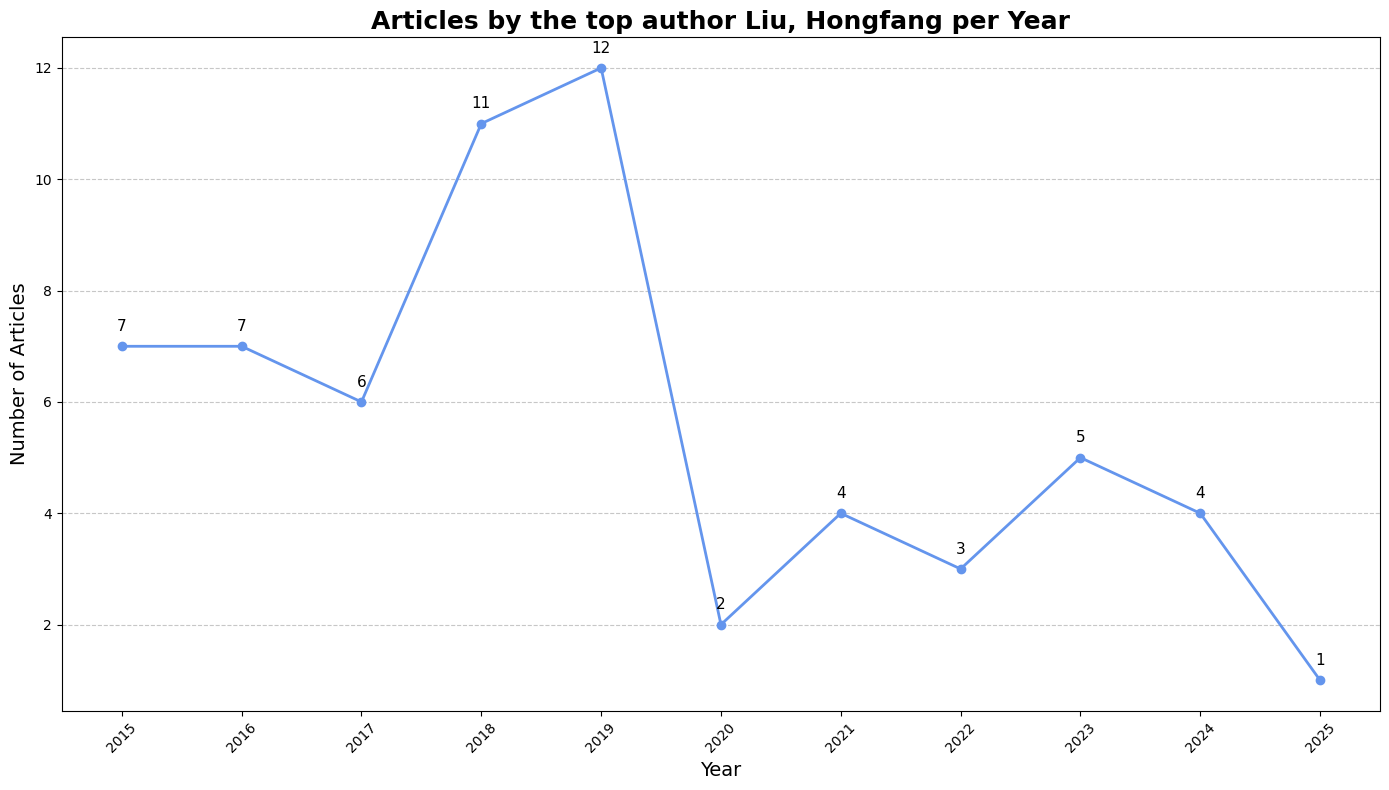

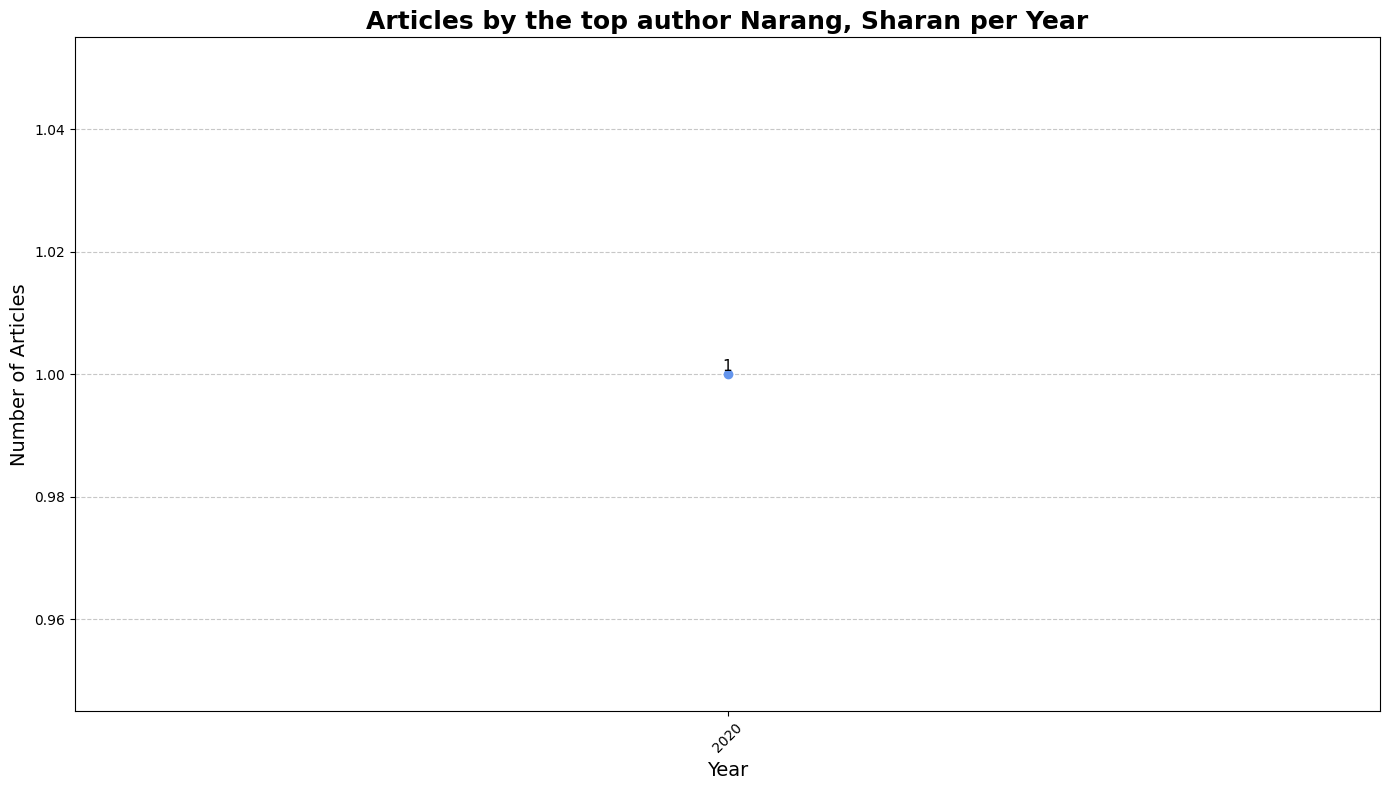

In [ ]:
# h-index 
def calculate_h_index(citations):
    citations = sorted(citations, reverse=True)
    h_index = 0
    for i, c in enumerate(citations):
        if c >= i + 1:
            h_index = i + 1
        else:
            break
    return h_index
# calculate each author's h-index
authors_df = articles_df[['Author full names', 'Cited by', 'Source title']].copy()
authors_df = authors_df.dropna(subset=['Author full names', 'Cited by'])
authors_df['Cited by'] = authors_df['Cited by'].astype(int)
authors_df['Author full names'] = authors_df['Author full names'].str.split(';')
authors_df = authors_df.explode('Author full names')
authors_df['Author full names'] = authors_df['Author full names'].str.strip()

authors_h_index = (authors_df.groupby('Author full names')['Cited by'].apply(lambda x: calculate_h_index(x.tolist())).sort_values(ascending=False).head(20))
authors_h_index.index = authors_h_index.index.str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()
create_bar_chart(authors_h_index, "Top 20 Authors by H-Index", "Author", "H-Index")

# top 20 authors by citations per publication (C/P)
authors_citations = authors_df.groupby('Author full names')['Cited by'].sum()
authors_publications = authors_df.groupby('Author full names')['Source title'].count()
valid_authors = authors_publications[authors_publications > 0].index
authors_citation_per_publication = ((authors_citations[valid_authors] / authors_publications[valid_authors]).sort_values(ascending=False))
authors_citation_per_publication_filtered = (authors_citation_per_publication.sort_values(ascending=False).head(20))
authors_citation_per_publication_filtered.index = authors_citation_per_publication_filtered.index.str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()
create_bar_chart(authors_citation_per_publication_filtered,"Top 20 Authors by Citations per Publication (C/P)","Author","C/P")

# show how many articles were written by the top author according to h-index in each year
top_author = authors_h_index.index[0]
top_author_articles = articles_df[articles_df['Author full names'].str.contains(top_author, na=False)]
top_author_per_year = top_author_articles['Year'].value_counts().sort_index()
create_line_chart(top_author_per_year, f"Articles by the top author {top_author} per Year", "Year", "Number of Articles")

# show how many articles were written by the top author according to C/P in each year
top_author_citation_per_publication = authors_citation_per_publication_filtered.index[0]
top_author_citation_per_publication_articles = articles_df[articles_df['Author full names'].str.contains(top_author_citation_per_publication, na=False)]
top_author_citation_per_publication_per_year = top_author_citation_per_publication_articles['Year'].value_counts().sort_index()
create_line_chart(top_author_citation_per_publication_per_year, f"Articles by the top author {top_author_citation_per_publication} per Year", "Year", "Number of Articles")


### Collaboration indicators

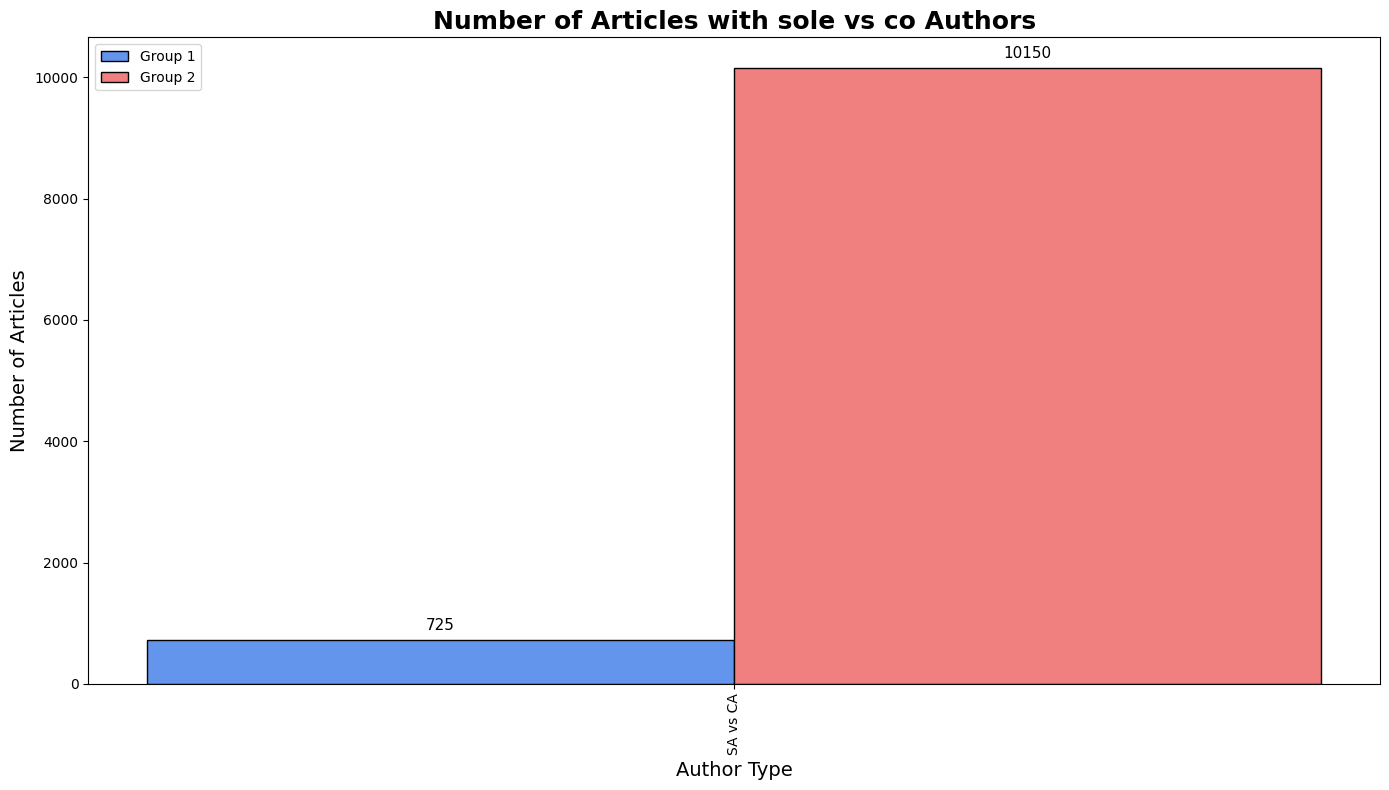

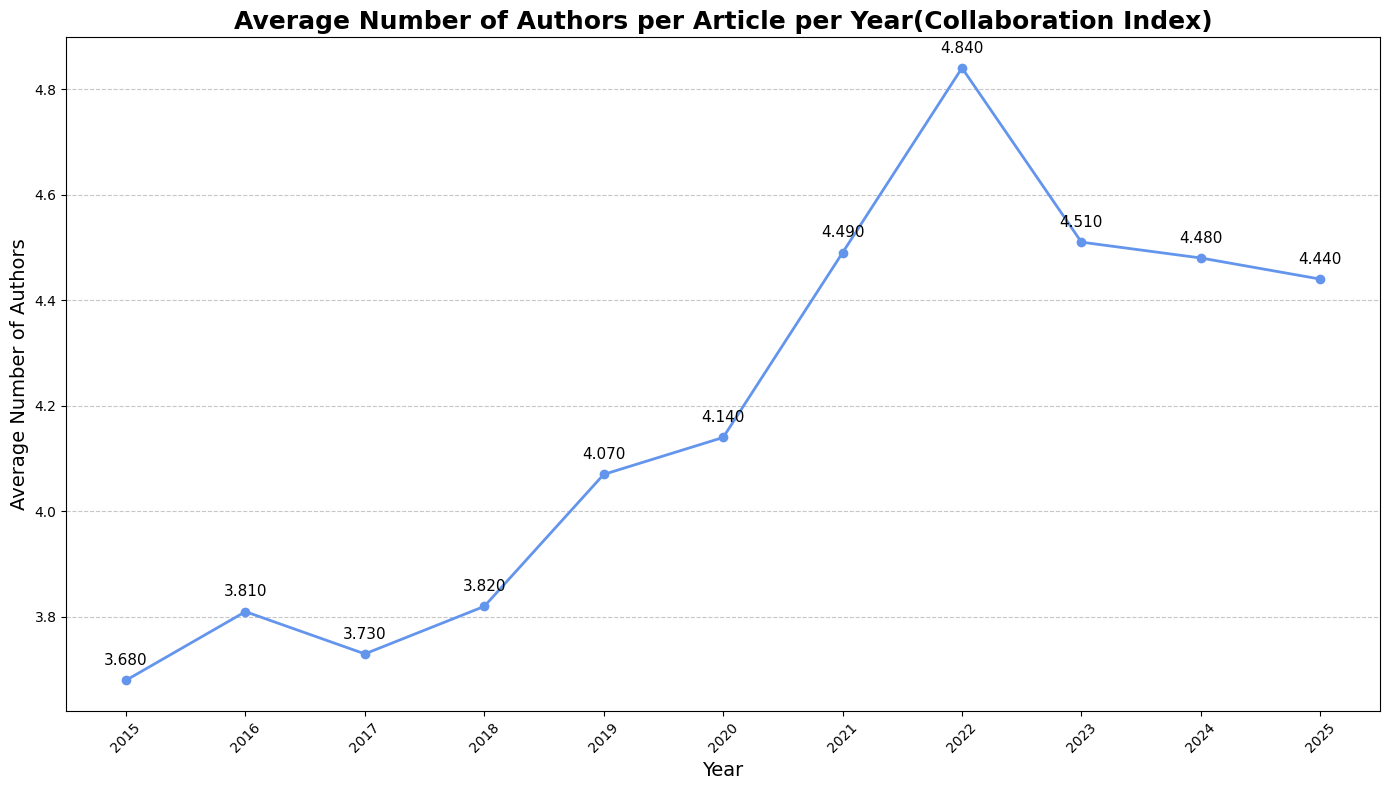

In [ ]:
single_authors_count = articles_df[articles_df['Author full names'].str.split(';').str.len() == 1].shape[0]
multiple_authors_count = articles_df[articles_df['Author full names'].str.split(';').str.len() > 1].shape[0]
create_grouped_bar_chart(["SA vs CA"],
                         [single_authors_count], [multiple_authors_count],
                         "Number of Articles with sole vs co Authors",
                         "Author Type", "Number of Articles")

yearly_authors_df = articles_df.dropna(subset=["Year", "Author full names"]).copy()
yearly_authors_df['Author Count'] = yearly_authors_df["Author full names"].apply(lambda x: len(str(x).split(';')))
avg_authors_per_year = (yearly_authors_df.groupby("Year")['Author Count'].mean().round(2).sort_index())
create_line_chart(avg_authors_per_year, "Average Number of Authors per Article per Year(Collaboration Index)", "Year", "Average Number of Authors")

## Science mapping
### Co‑authorship analysis

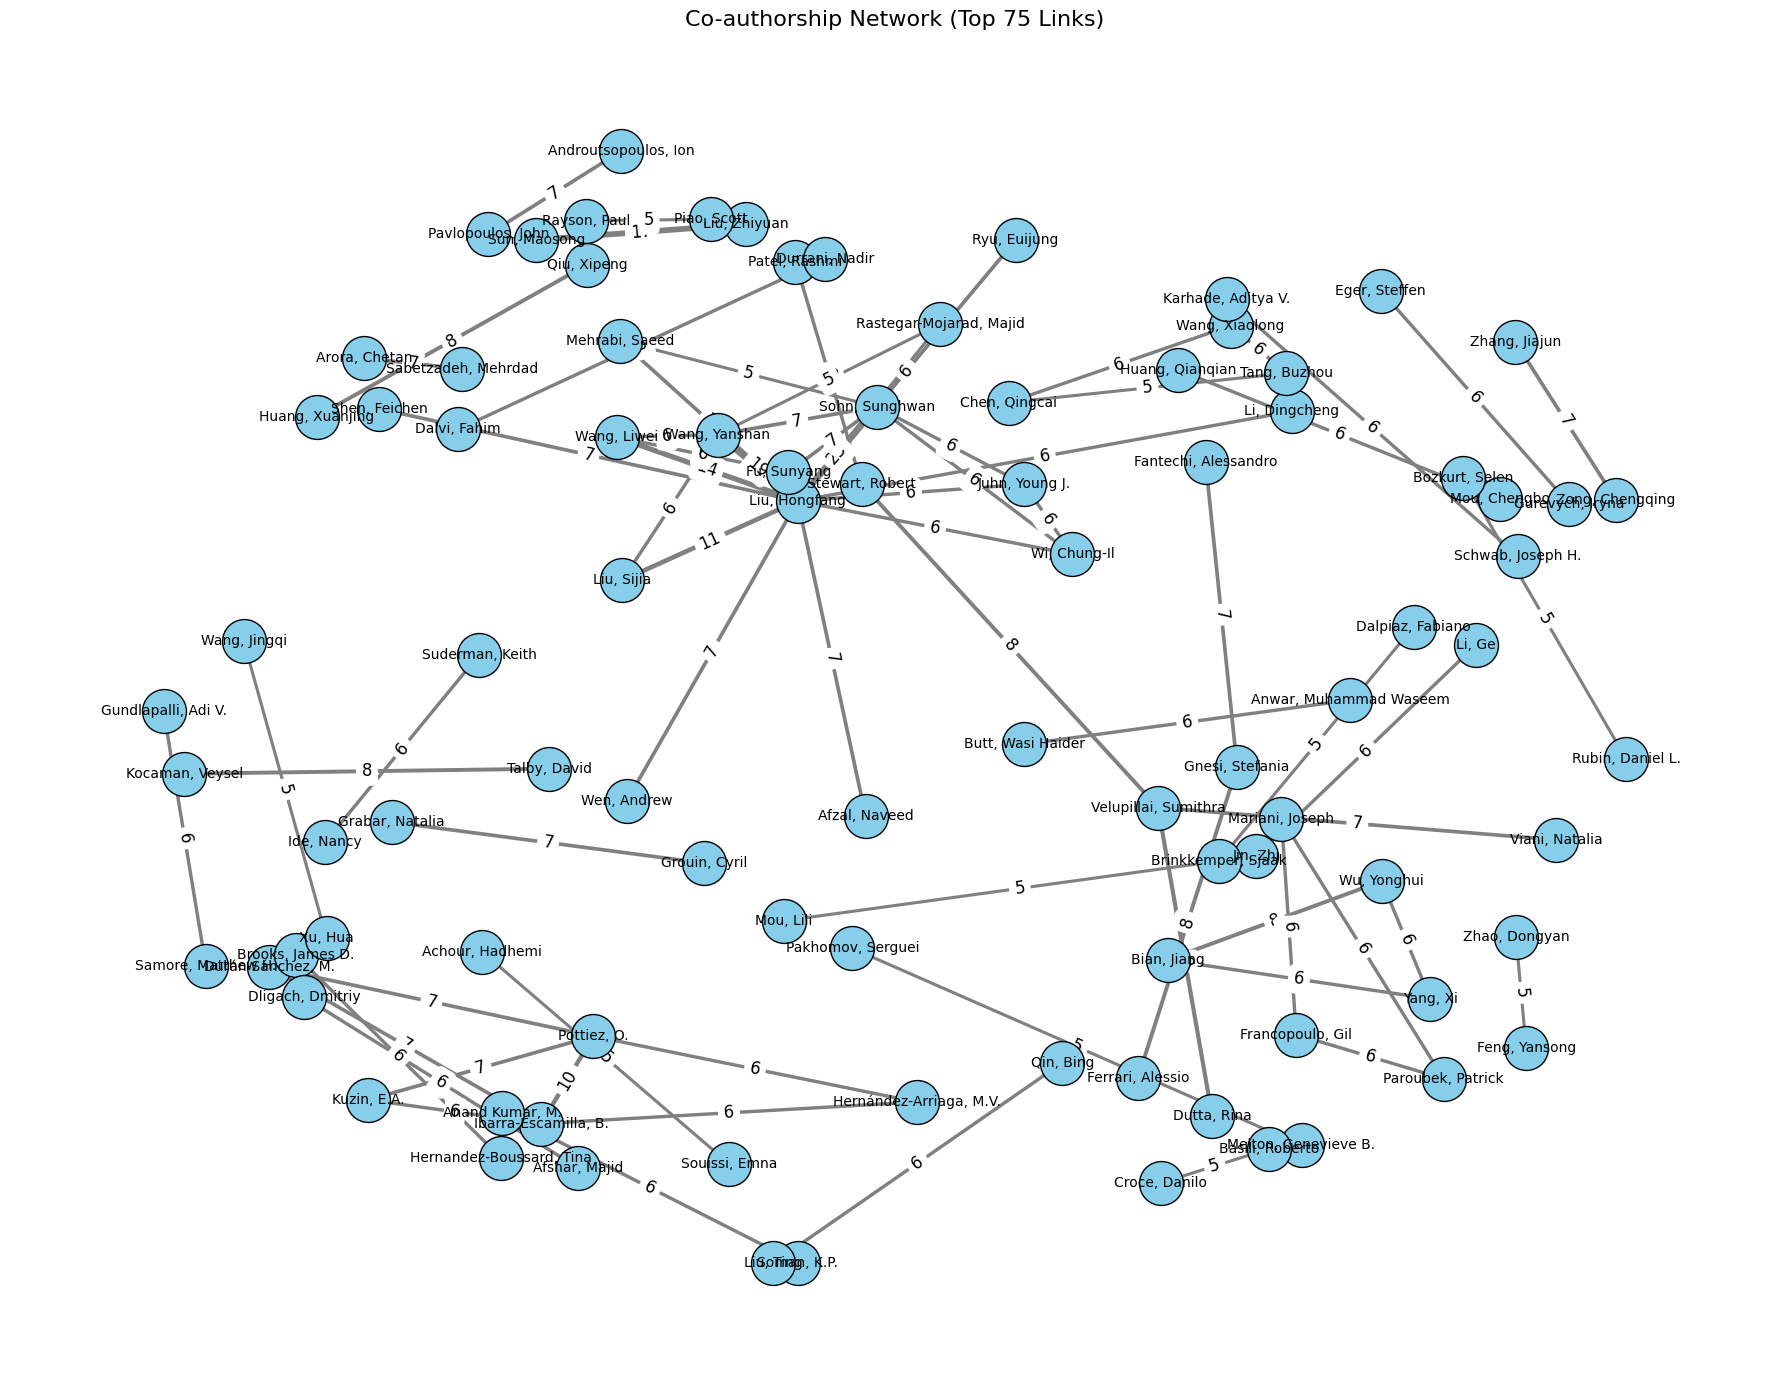

In [ ]:
def clean_name(name):
    return re.sub(r'\s*\(.*?\)', '', name).strip()

author_df = articles_df[['Year', 'Author full names']].dropna().copy()
author_df['Author full names'] = author_df['Author full names'].str.split(';')
author_df['Author full names'] = author_df['Author full names']
coauthor_pairs = []
for authors in author_df['Author full names']:
    authors = [a.strip() for a in authors if a.strip()]
    coauthor_pairs.extend(combinations(set(authors), 2))

coauthor_counts = Counter(coauthor_pairs)
top_coauthors = dict(coauthor_counts.most_common(75))
top_coauthors = {
    (clean_name(a), clean_name(b)): w for (a, b), w in top_coauthors.items()
}
G = nx.Graph()
G.add_edges_from([(a, b, {'weight': w}) for (a, b), w in top_coauthors.items()])
pos = nx.spring_layout(G, k=1, seed=42)
edge_labels = {(a, b): f"{w}" for (a, b), w in top_coauthors.items()}
plt.figure(figsize=(18, 14)) 
weights = [d['weight'] for (_, _, d) in G.edges(data=True)]
edge_widths = [w**0.5 for w in weights]
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue', edgecolors='black')
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
plt.title("Co-authorship Network (Top 75 Links)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


### Citation analysis

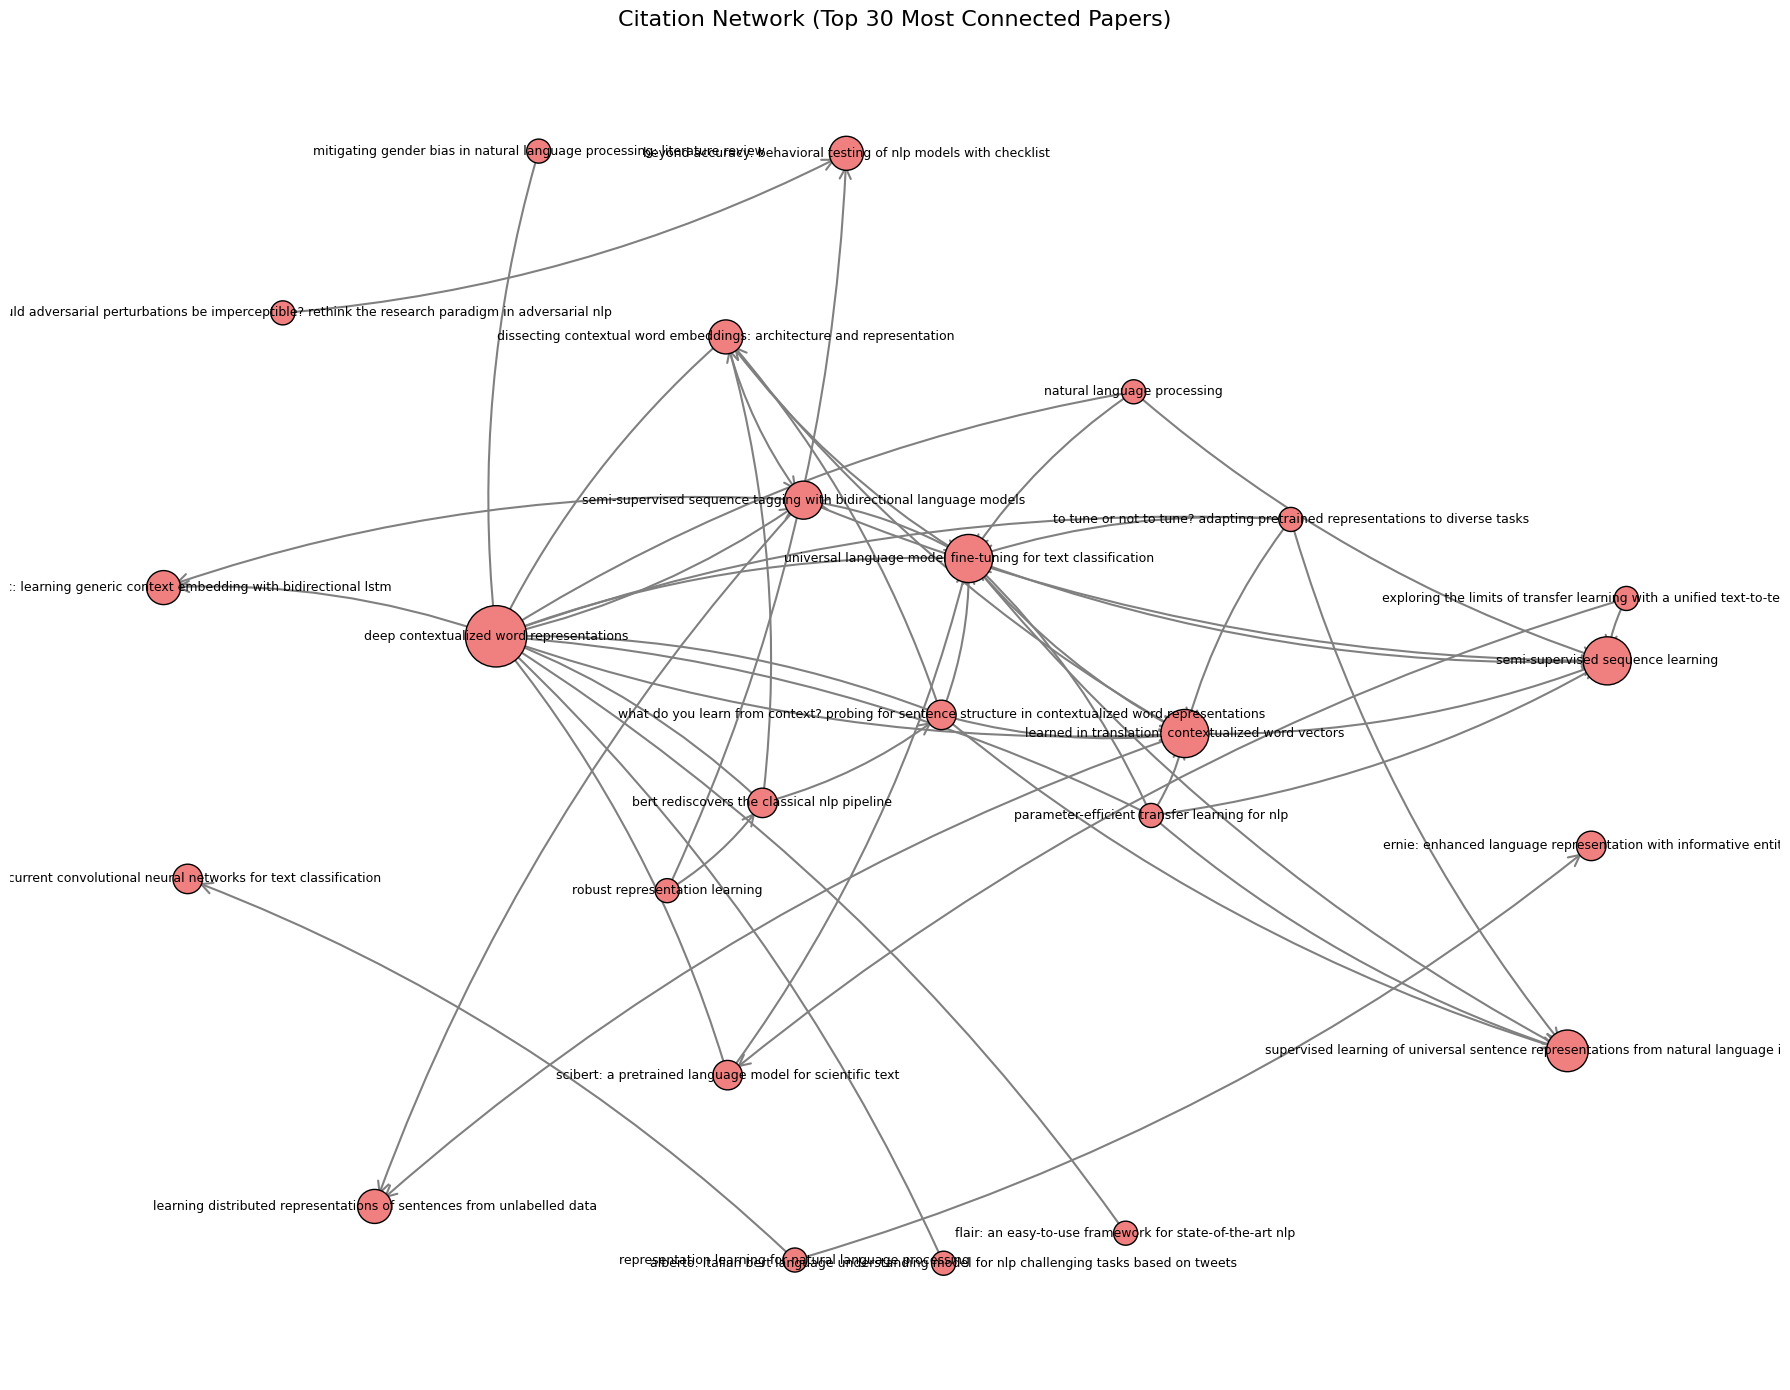

In [ ]:
def clean_text(text):
    return re.sub(r'\s+', ' ', text.strip().lower())

articles_df['clean_title'] = articles_df['Title'].apply(clean_text)
def extract_reference_titles(ref_string):
    refs = ref_string.split(';')
    titles = []
    for ref in refs:
        match = re.search(r',\s*([^,]+),[^,]+,\s*\(?(19|20)\d{2}\)?', ref)
        if match:
            title = match.group(1)
            titles.append(clean_text(title))
        else:
            titles.append(clean_text(ref))
    return titles

citation_edges = []
for _, row in articles_df[['Title', 'References']].dropna().iterrows():
    citing_title = clean_text(row['Title'])
    reference_titles = extract_reference_titles(row['References'])
    for cited_title in reference_titles:
        if cited_title in articles_df['clean_title'].values:
            citation_edges.append((citing_title, cited_title))
node_degree = defaultdict(int)
for a, b in citation_edges:
    node_degree[a] += 1
    node_degree[b] += 1
top_n = 30
top_nodes = set([node for node, _ in sorted(node_degree.items(), key=lambda x: x[1], reverse=True)[:top_n]])
filtered_edges = [(a, b) for a, b in citation_edges if a in top_nodes and b in top_nodes]
G = nx.DiGraph()
G.add_edges_from(filtered_edges)
plt.figure(figsize=(18, 14))
pos = nx.spring_layout(G, k=1.2, seed=42)

in_degrees = dict(G.in_degree())
node_sizes = [300 + in_degrees.get(node, 0) * 150 for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightcoral', edgecolors='black')
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowstyle='->', arrowsize=20, width=1.5, connectionstyle='arc3,rad=0.1')
nx.draw_networkx_labels(G, pos, font_size=9)

plt.title("Citation Network (Top 30 Most Connected Papers)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


### Keyword analysis

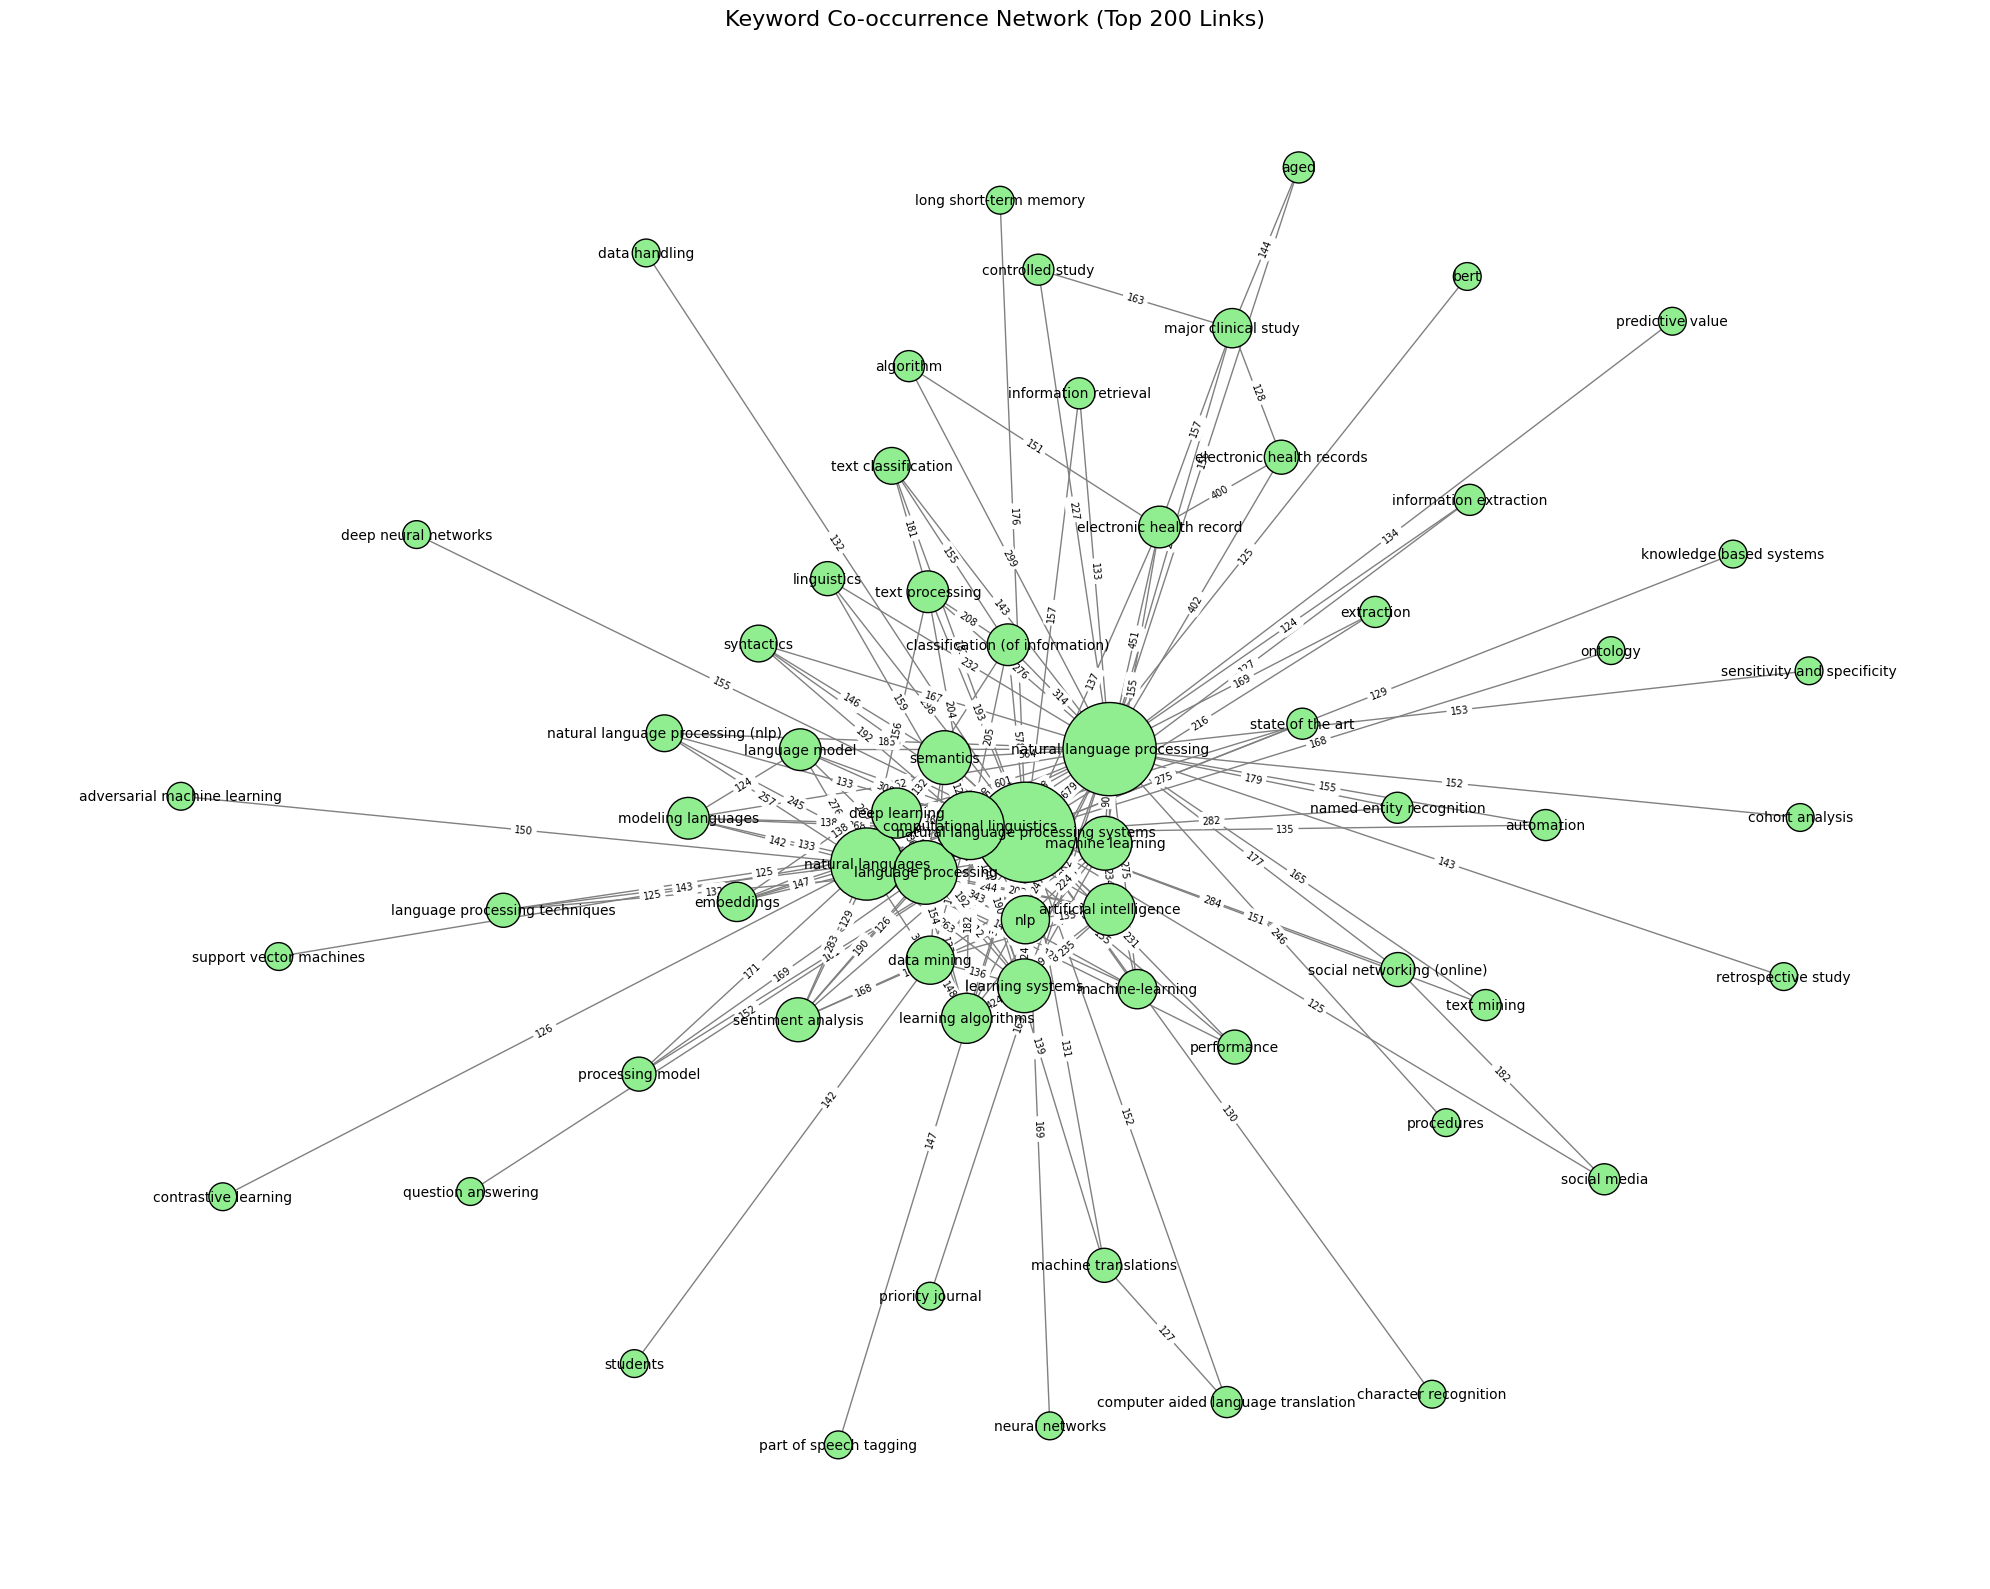

In [ ]:
keyword_df = articles_df[['Combined Keywords']].dropna().copy()
co_keyword_pairs = []
for kw_list in keyword_df['Combined Keywords']:
    unique_keywords = set(kw_list)
    co_keyword_pairs.extend(combinations(unique_keywords, 2))
co_keyword_counts = Counter(co_keyword_pairs)
top_co_keywords = dict(co_keyword_counts.most_common(200))
G = nx.Graph()
G.add_edges_from([(a, b, {'weight': w}) for (a, b), w in top_co_keywords.items()])
plt.figure(figsize=(20, 16))
pos = nx.spring_layout(G, k=1.2, seed=42)
degrees = dict(G.degree())
node_sizes = [300 + degrees[node] * 100 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightgreen', edgecolors='black')
nx.draw_networkx_edges(G, pos, width=1, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10)
edge_labels = {(a, b): f"{d['weight']}" for a, b, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title("Keyword Co-occurrence Network (Top 200 Links)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

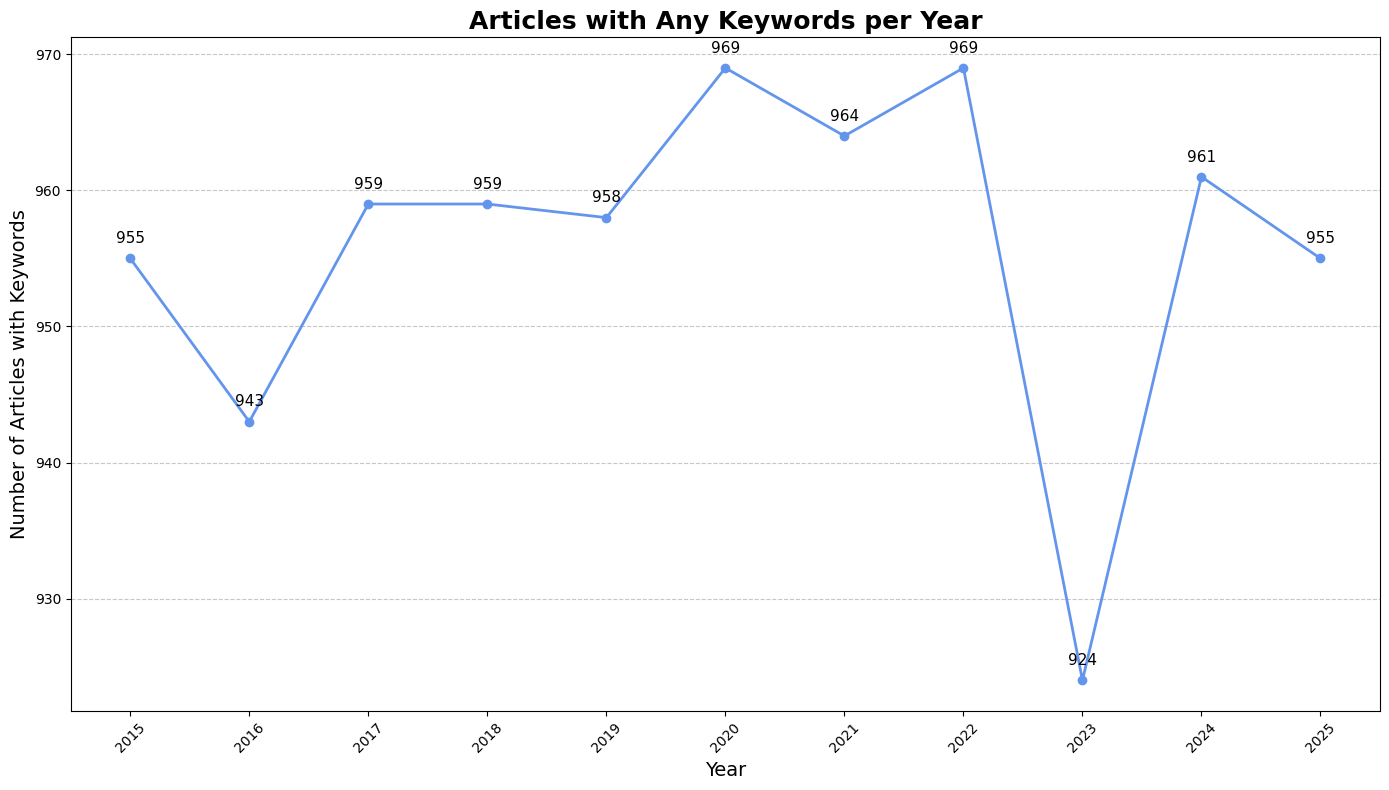

In [ ]:
# show how much articles have keywords in each year
articles_df['Has Any Keywords'] = articles_df['Combined Keywords'].apply(lambda x: len(x) > 0)
articles_per_year_keywords = articles_df.groupby('Year')['Has Any Keywords'].value_counts().unstack().fillna(0)
articles_per_year_keywords = articles_per_year_keywords.sort_index()
create_line_chart(articles_per_year_keywords[True], "Articles with Any Keywords per Year", "Year", "Number of Articles with Keywords")

### Showing most present keywords, and trends over the years

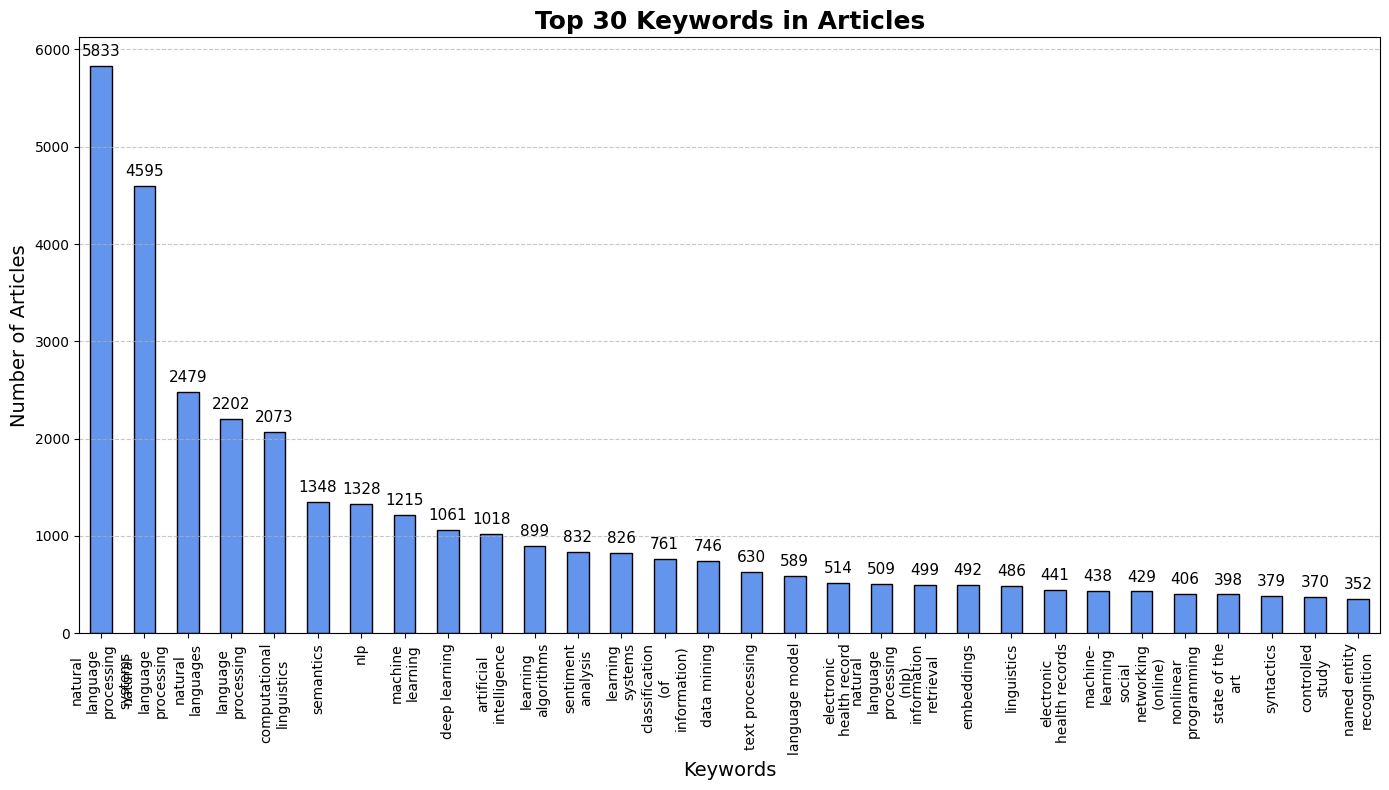

In [ ]:
all_keywords = articles_df['Combined Keywords'].explode().dropna()
keyword_counts = all_keywords.value_counts().head(30)
create_bar_chart(keyword_counts, "Top 30 Keywords in Articles", "Keywords", "Number of Articles")
create_wordcloud(dict(keyword_counts), "Top 30 Keywords in Articles")

### Showing the most popular keywords over time(removing some of the top ones as they are too broad)

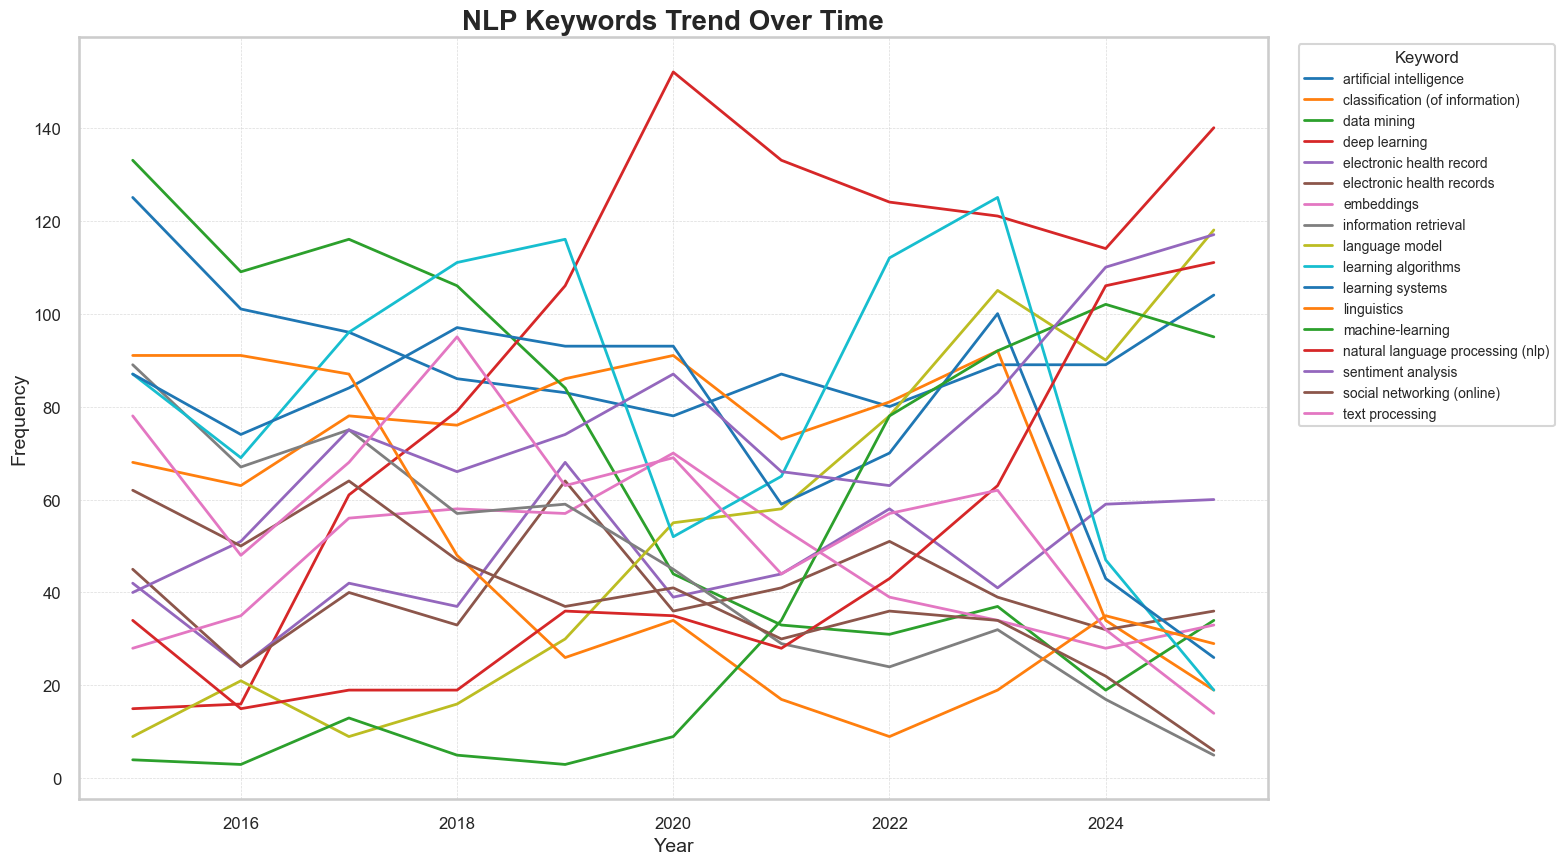

In [ ]:
top_keywords = keyword_counts.index.tolist()[8:25]
articles_df['Combined Keywords'] = articles_df['Combined Keywords'].apply(lambda x: [kw.strip().lower() for kw in x] if isinstance(x, list) else [])
keywords_year_df = articles_df.explode('Combined Keywords')
keywords_year_df = keywords_year_df[keywords_year_df['Combined Keywords'].isin(top_keywords)]
trend_data = (keywords_year_df.groupby(['Year', 'Combined Keywords']).size().unstack(fill_value=0).sort_index())
sns.set_theme(style="whitegrid", context="talk", palette="tab10")
plt.figure(figsize=(16, 9))
for keyword in trend_data.columns:
    plt.plot(trend_data.index, trend_data[keyword], label=keyword, linewidth=2)
plt.title("NLP Keywords Trend Over Time", fontsize=20, weight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Keyword", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

### Showing highly correlated keywords
### Pairs that got a 1 score means that those keywords always appeared together in an article

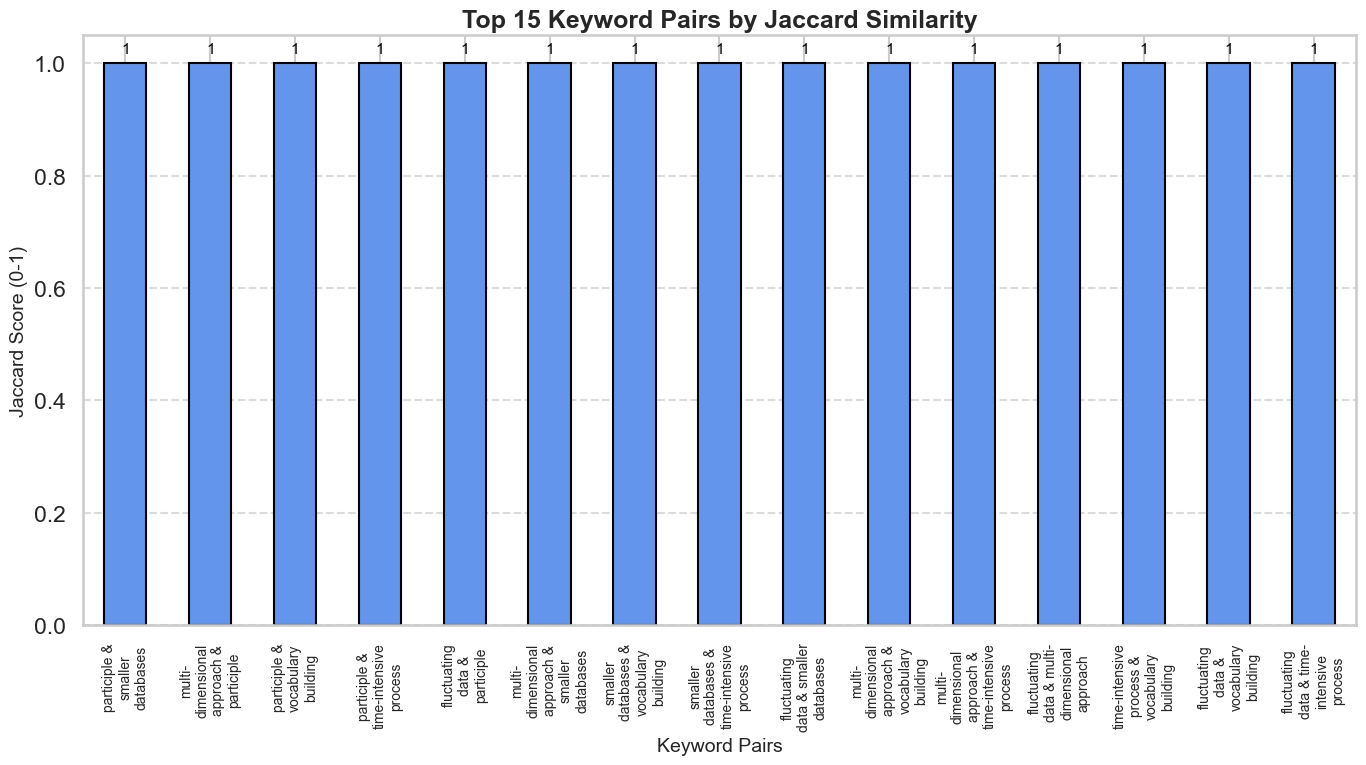

In [ ]:
keyword_df = articles_df[['Combined Keywords']].dropna().copy()
keyword_freq = defaultdict(int)
co_occurrence = defaultdict(int)
for kw_list in keyword_df['Combined Keywords']:
    kws = set(kw_list)
    for kw in kws:
        keyword_freq[kw] += 1
    for pair in combinations(kws, 2):
        pair = tuple(sorted(pair))
        co_occurrence[pair] += 1
jaccard_scores = {}
for (kw1, kw2), co_count in co_occurrence.items():
    total = keyword_freq[kw1] + keyword_freq[kw2] - co_count
    jaccard_scores[(kw1, kw2)] = co_count / total if total > 0 else 0
top_jaccard = dict(sorted(jaccard_scores.items(), key=lambda x: x[1], reverse=True)[:15])
labels = [f"{a} & {b}" for a, b in top_jaccard]
scores = list(top_jaccard.values())
create_bar_chart(pd.Series(scores, index=labels),
                 "Top 15 Keyword Pairs by Jaccard Similarity",
                 "Keyword Pairs", "Jaccard Score (0-1)")

### Using statistical prominence(z-scores) showing raising or unusually frequent keywords - helps identify each year's trends in NLP research
### Some clear ones are covid-19 raising in 2022, LLMs and chatbots dominating 2025 research

In [ ]:
keyword_year_df = articles_df[['Year', 'Combined Keywords']].explode('Combined Keywords')
keyword_year_df = keyword_year_df.dropna()
keyword_counts = keyword_year_df.groupby(['Combined Keywords', 'Year']).size().unstack(fill_value=0)

min_total_count = 60
total_counts = keyword_counts.sum(axis=1)
keyword_counts = keyword_counts[total_counts >= min_total_count]

z_scores = (keyword_counts - keyword_counts.mean(axis=1).values[:, None]) / keyword_counts.std(axis=1).values[:, None]
z_scores = z_scores.fillna(0)

top_z_keywords_per_year = {}
min_year_count = 20
for year in z_scores.columns:
    valid_keywords = keyword_counts[year] >= min_year_count
    filtered_z = z_scores[year][valid_keywords]
    top_keywords = filtered_z.sort_values(ascending=False).head(8)
    top_z_keywords_per_year[year] = top_keywords

keyword_only_dict = {
    year: list(keywords.index) for year, keywords in top_z_keywords_per_year.items()
}

trend_df_keywords = pd.DataFrame.from_dict(keyword_only_dict, orient='index')
trend_df_keywords.columns = [f"Place {i+1}" for i in range(trend_df_keywords.shape[1])]

display(trend_df_keywords)

Place 1                              Place 2  \
2015                     classification                       bioinformatics   
2016               knowledge management            word sense disambiguation   
2017                          education                 software engineering   
2018  nlp (natural language processing)            recurrent neural networks   
2019          electronic health records                            algorithm   
2020                 question answering  computer aided language translation   
2021                  transfer learning                         pre-training   
2022                           covid-19                          down-stream   
2023                         e-learning                          performance   
2024                   network security                 contrastive learning   
2025                emotion recognition                large language models   

                            Place 3                      Place 4  \
2015                       genetics      artificial intelligence   
2016                       ontology                 optimization   
2017           information analysis                  convolution   
2018           network architecture       long short-term memory   
2019            medical informatics     electronic health record   
2020  convolutional neural networks             state of the art   
2021                      pipelines  sensitivity and specificity   
2022               controlled study         major clinical study   
2023                   transformers             processing model   
2024   adversarial machine learning  economic and social effects   
2025                 large datasets             knowledge graphs   

                             Place 5                        Place 6  \
2015       electronic medical record                   semantic web   
2016           nonlinear programming                    linguistics   
2017                 neural networks  information retrieval systems   
2018                 text processing   convolutional neural network   
2019            major clinical study                 search engines   
2020            deep neural networks            text classification   
2021           retrospective studies               predictive value   
2022             retrospective study                    forecasting   
2023           character recognition                    transformer   
2024  language processing techniques                  data handling   
2025            large language model                       teaching   

                           Place 7                     Place 8  
2015                    procedures                 text mining  
2016          information analysis                semantic web  
2017  convolutional neural network  social networking (online)  
2018                   convolution    named entity recognition  
2019   sensitivity and specificity              word embedding  
2020                   fine tuning        machine translations  
2021               cohort analysis              word embedding  
2022              predictive value            processing model  
2023           language processing              language model  
2024           machine translation                benchmarking  
2025                     diagnosis                    chatbots

### Showing how the First place of each year is reaching the peak in that year of research  

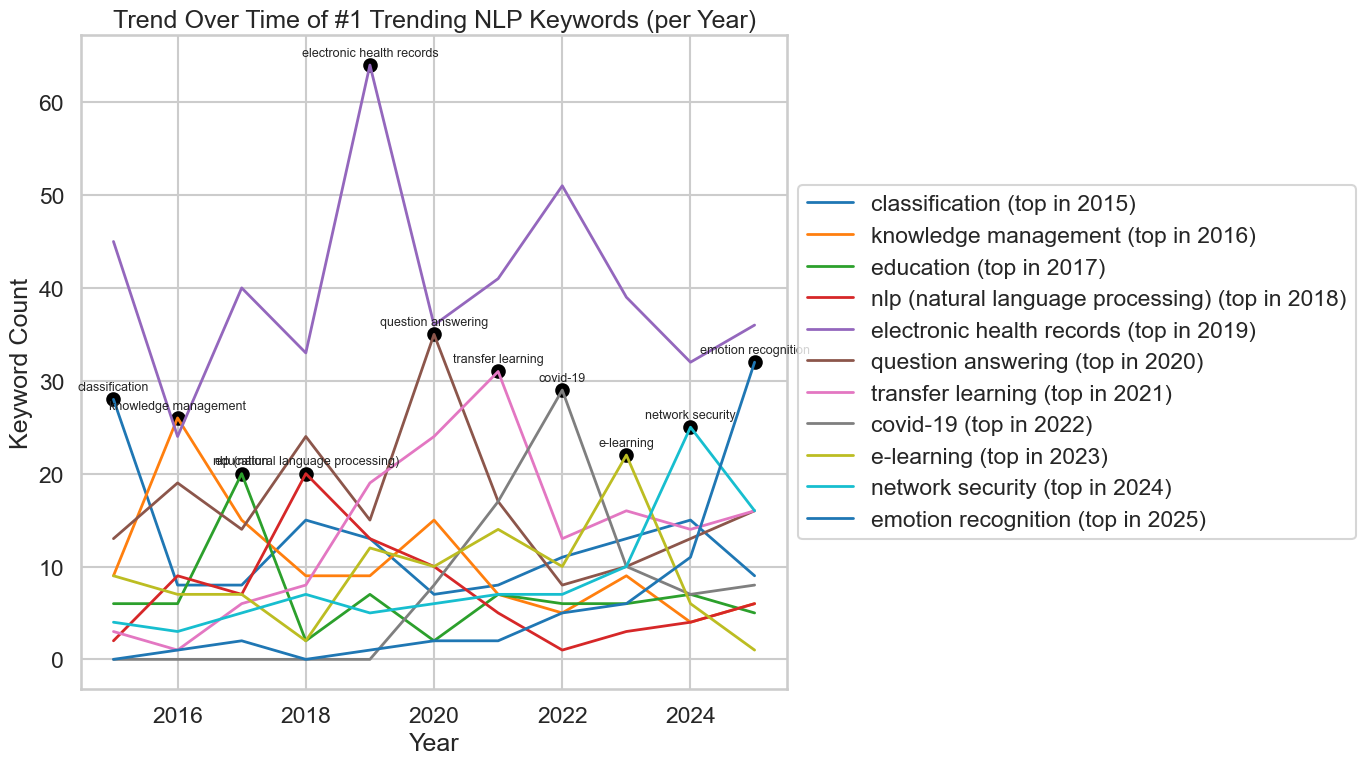

In [ ]:
import matplotlib.pyplot as plt

top_keywords = trend_df_keywords["Place 1"]

plt.figure(figsize=(14, 8))
for year, keyword in top_keywords.items():
    if keyword in keyword_counts.index:
        counts = keyword_counts.loc[keyword]
        plt.plot(
            counts.index, counts.values,
            label=f"{keyword} (top in {year})",
            linewidth=2
        )
        peak_year = counts.idxmax()
        peak_value = counts.max()
        plt.scatter([peak_year], [peak_value], color='black')
        plt.text(peak_year, peak_value + 1, keyword, fontsize=9, ha='center')
plt.xlabel("Year")
plt.ylabel("Keyword Count")
plt.title("Trend Over Time of #1 Trending NLP Keywords (per Year)")
plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

### 10. Abstracts summarization - using the t5-small model

In [ ]:
summarizer = pipeline("summarization", model="t5-small")
def summarize_text(text):
    try:
        summary = summarizer("summarize: " + text, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return ""
SUM_N = 30
summarized_abstracts = [summarize_text(abstract) for abstract in abstracts[:SUM_N] if isinstance(abstract, str)]


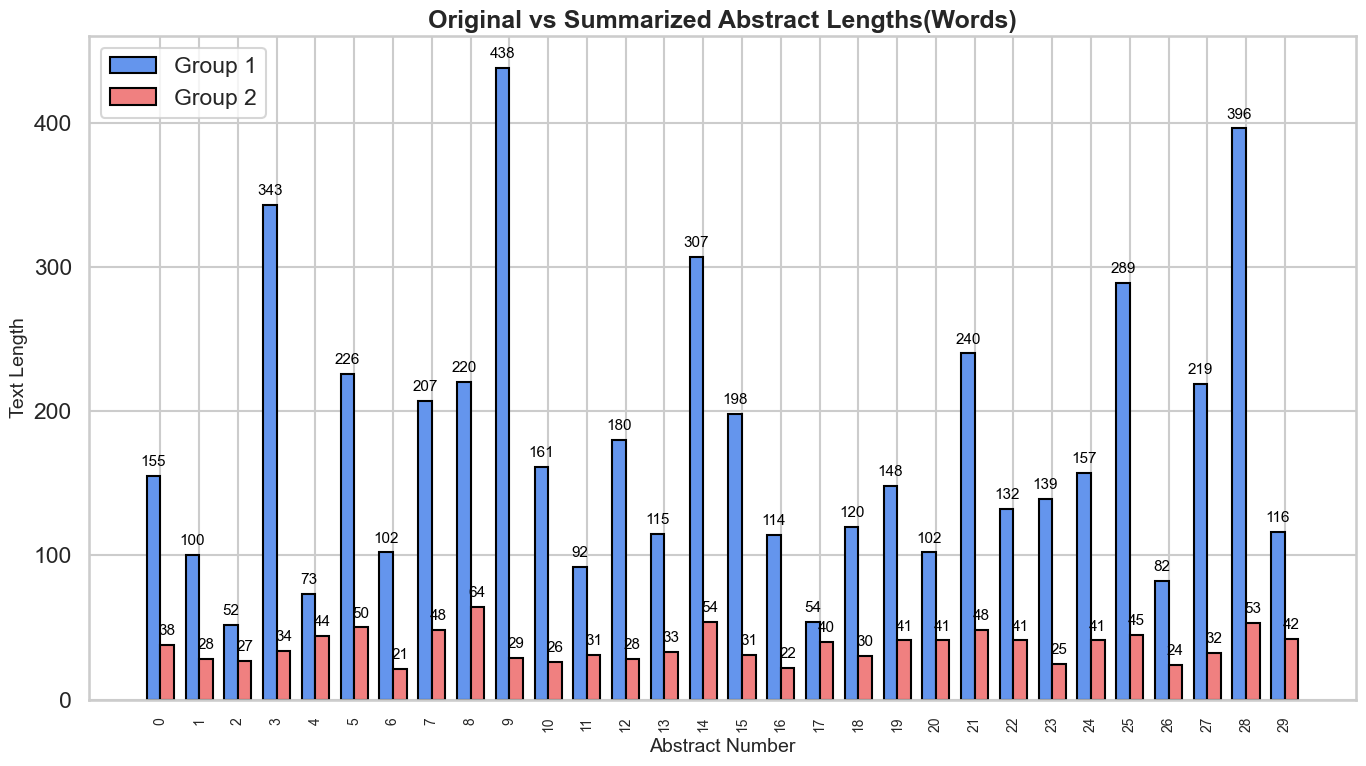

In [ ]:
original_lengths = [len(abstract.split()) for abstract in abstracts[:SUM_N] if isinstance(abstract, str)]
summary_lengths = [len(summary.split()) for summary in summarized_abstracts if isinstance(summary, str)]


indices = range(len(original_lengths))

create_grouped_bar_chart(indices, original_lengths, summary_lengths,
                          "Original vs Summarized Abstract Lengths(Words)",
                            "Abstract Number", "Text Length")

### 11. To get GPT to analyze each year's trends, I have picked 10 articles from each year -  with the most citations - and thus represent it the most.
### Than summarized each of their abstracts, concat them, and let GPT get the keywords from them 

In [ ]:
top_articles_by_citations_each_year = articles_df.groupby('Year').apply(
    lambda x: x.nlargest(10, 'Cited by')[['Title', 'Cited by', 'Abstract', 'Year']]
).reset_index(drop=True)

summarized_per_year = {}

grouped = top_articles_by_citations_each_year.groupby('Year')
for year, top_df in grouped:
    article_abstracts = top_df["Abstract"].dropna().astype(str).tolist()
    article_summaries = [summarize_text(abstract) for abstract in article_abstracts]
    final_summary = "\n".join(article_summaries)
    summarized_per_year[year] = final_summary
    print(f"{year}:\n{final_summary}\n")

2015:
text classification is a foundational task in many NLP applications . traditional text classifiers often rely on many human-designed features . we use a recurrent structure to capture contextual information .
traditional approaches to event extraction rely on elaborately designed features and complicated natural language processing tools . this paper proposes a novel event-extraction method, which aims to automatically extract lexical-level and sentence-level features without using complicated NLP tools.
we present two approaches to use unlabeled data to improve Sequence Learning . the first approach is to predict what comes next in a sequence, which is a language model .
relationship classification is an important research arena in the field of natural language processing (NLP) in this paper, we present SDP-LSTM, a novel neural network to classify relation of two entities in a sentence.
Sentiment analysis is one of the major tasks of NLP (Natural Language Processing) in recent y

### The keywords extracted varies in quality and not deterministic, often hallucinated. Most of the times it does recognize the presence of NLP, AI and some other fields researched with NLP over the years

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model.eval()

def extract_topics_with_gpt(prompt_text,max_new_tokens=50):
    inputs = tokenizer.encode(prompt_text, return_tensors='pt', truncation=True)
    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.9,
            top_k=50,
            top_p=0.95,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

summarized_topics_per_year = {}
for year, combined in summarized_per_year.items():
    prompt = f"What are the main research topics discussed in the following abstracts?\n\n{combined}\n\nTopics:"
    gpt_output = extract_topics_with_gpt(prompt)
    if "Topics:" in gpt_output:
        gpt_output = gpt_output.split("Topics:")[-1].strip()
    summarized_topics_per_year[year] = gpt_output
    print(f"{year}:\n{gpt_output}")


2015:
human-readable, natural-language-processing, human-readable, natural-language-processing, natural-language-processing, human-readable-language-processing, human-readable-language-processing, human-readable-language-processing,
2016:
natural-language-processing, language processing, nLP, neural-plastic-processing, nLP, neural-plastic-processing, nLP
2017:
human-network, human-network, human-network, human-network, human-network, human-network, human-network, human-network, human-network, human-network, human-network, human-network, human-
2018:
nLP, non-linearity, the-state-of-art, human-language, the-relationship-building, lexical-language, semantic-conversation
a review of new research, especially the present study, can
2019:
neuroscience, neuroscience, neuroscience, neuroscience
The Open Source Project
http://www.opensource.org/
Please join us on Facebook, Twitter, LinkedIn, Google+
2020:
software-intelligence, science-and-technology, computer-technology, artificial-intelligenc

In [ ]:
processed_texts_per_year = {
    year: ' '.join([
        token.lemma_.lower()
        for token in nlp(text)
        if not token.is_stop and not token.is_punct and token.lemma_.isalpha()
    ])
    for year, text in summarized_topics_per_year.items()
}
unique_words_per_year = []
for year, text in processed_texts_per_year.items():
    tokens = text.split()
    unique_tokens = set(tokens)
    unique_words_per_year.extend(unique_tokens)
word_freq = Counter(unique_words_per_year)
top_words = word_freq.most_common(10)
top_words_series = pd.Series(dict(top_words))
create_bar_chart(top_words_series,"Top 10 Distinct Words in GPT Topics (by Year Coverage)","Words","Years Appeared")

c:\NLP\Final-project\Project3\.venv\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


### 12. It is clear that using EDA methods on the data in 9 let to better trends and keywords analysis than using Question-Answering GPT2 with samples of article summarizations, due to limited resources I couldn't use a more powerful GPT model, which may improve significantly the results. Also the prompt length limitations prevent it from getting all of the year's data - which can prevent fully understanding that year.    